<a href="https://colab.research.google.com/github/rismawidiyanti/news-rnn-lstm/blob/main/UAS_RNN_LSTM_Encoder_Decoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install gensim nltk newsapi-python
!pip install -q rouge tqdm

In [ ]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import json
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from gensim.models import Word2Vec
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
from nltk.translate.bleu_score import sentence_bleu, corpus_bleu
from rouge import Rouge
from tqdm.notebook import tqdm

In [ ]:
# Download NLTK resources
nltk.download('punkt_tab')
nltk.download('stopwords')


[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
# Mengatur seed untuk reproduksibilitas
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
# inspect_csv.py
import csv

# Muat dataset
df = pd.read_csv('/content/bbc-news-data.csv', sep=None, engine='python')

# Menampilkan informasi dataset
print("Informasi Dataset:")
print(f"Jumlah baris: {df.shape[0]}")
print(f"Jumlah kolom: {df.shape[1]}")
print("\nContoh data:")
display(df.head())

Informasi Dataset:
Jumlah baris: 2225
Jumlah kolom: 4

Contoh data:


,category,filename,title,content
0,business,001.txt,Ad sales boost Time Warner profit,Quarterly profits at US media giant TimeWarne...
1,business,002.txt,Dollar gains on Greenspan speech,The dollar has hit its highest level against ...
2,business,003.txt,Yukos unit buyer faces loan claim,The owners of embattled Russian oil giant Yuk...
3,business,004.txt,High fuel prices hit BA's profits,British Airways has blamed high fuel prices f...
4,business,005.txt,Pernod takeover talk lifts Domecq,Shares in UK drinks and food firm Allied Dome...


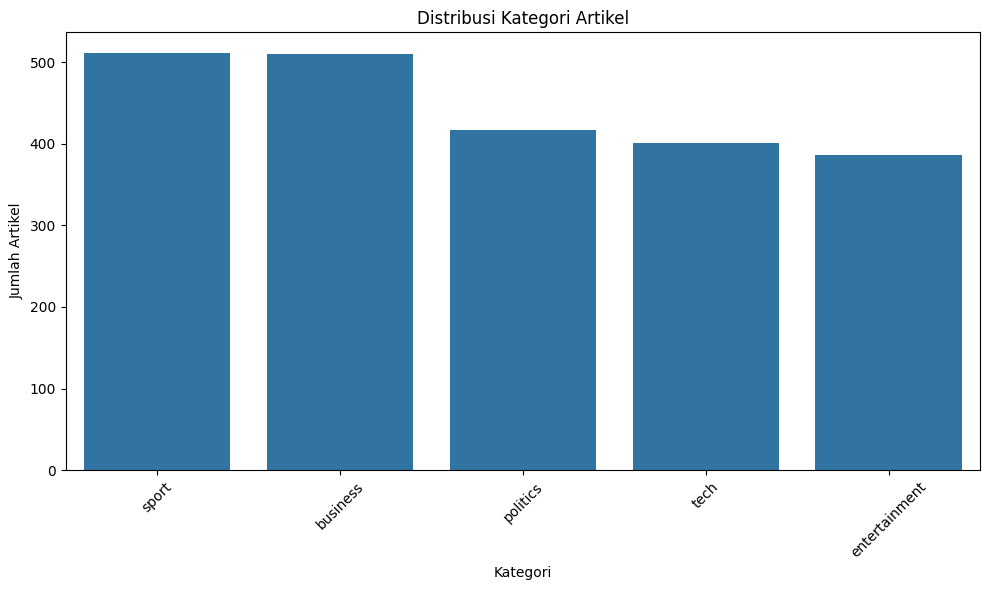


Distribusi kategori artikel:
category
sport            511
business         510
politics         417
tech             401
entertainment    386
Name: count, dtype: int64

Statistik panjang artikel:
        text_length  title_length
count   2225.000000   2225.000000
mean    2232.793258     31.367191
std     1364.249946      2.605422
min      471.000000     16.000000
25%     1414.000000     31.000000
50%     1936.000000     32.000000
75%     2774.000000     33.000000
max    25454.000000     52.000000


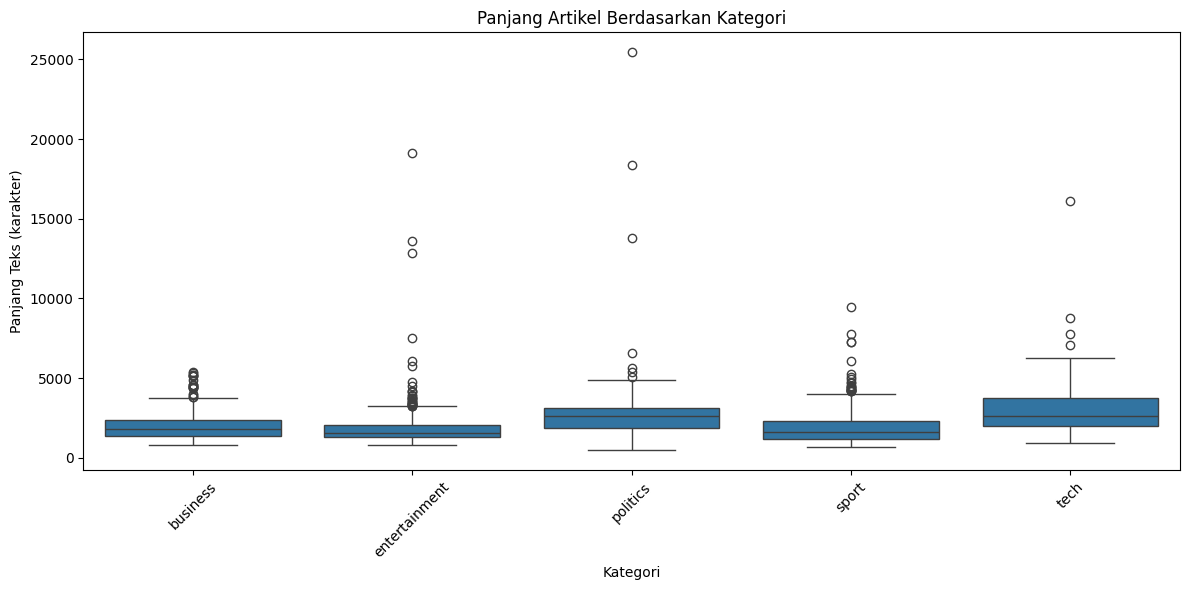

In [ ]:
# Visualisasi distribusi kategori
plt.figure(figsize=(10, 6))
sns.barplot(x=category_counts.index, y=category_counts.values)
plt.title('Distribusi Kategori Artikel')
plt.xlabel('Kategori')
plt.ylabel('Jumlah Artikel')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Memeriksa kategori artikel
print("\nDistribusi kategori artikel:")
category_counts = df['category'].value_counts()
print(category_counts)

# Memeriksa panjang artikel
df['text_length'] = df['content'].apply(len)
df['title_length'] = df['title'].apply(len)

print("\nStatistik panjang artikel:")
print(df[['text_length', 'title_length']].describe())

# Visualisasi panjang artikel berdasarkan kategori
plt.figure(figsize=(12, 6))
sns.boxplot(x='category', y='text_length', data=df)
plt.title('Panjang Artikel Berdasarkan Kategori')
plt.xlabel('Kategori')
plt.ylabel('Panjang Teks (karakter)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
# Memeriksa missing values
print("\nJumlah nilai yang hilang:")
print(df.isnull().sum())


Jumlah nilai yang hilang:
category        0
filename        0
title           0
content         0
text_length     0
title_length    0
dtype: int64


In [ ]:
# Fungsi preprocessing teks
def preprocess_text(text):
    if not isinstance(text, str):
        return []

    # Mengubah ke lowercase
    text = text.lower()

    # Menghapus tanda baca
    text = re.sub(f'[{string.punctuation}]', ' ', text)

    # Menghapus angka
    text = re.sub(r'\d+', '', text)

    # Tokenisasi
    tokens = word_tokenize(text)

    # Menghapus stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words and len(word) > 2]

    return tokens

# Preprocessing data
print("Melakukan preprocessing data...")
df['tokens'] = df['content'].apply(preprocess_text)

# Memeriksa jumlah token rata-rata per artikel
df['token_count'] = df['tokens'].apply(len)
print(f"\nRata-rata jumlah token per artikel: {df['token_count'].mean():.2f}")
print(f"Median jumlah token per artikel: {df['token_count'].median():.2f}")
print(f"Min jumlah token per artikel: {df['token_count'].min()}")
print(f"Max jumlah token per artikel: {df['token_count'].max()}")


Melakukan preprocessing data...

Rata-rata jumlah token per artikel: 208.23
Median jumlah token per artikel: 181.00
Min jumlah token per artikel: 43
Max jumlah token per artikel: 2128


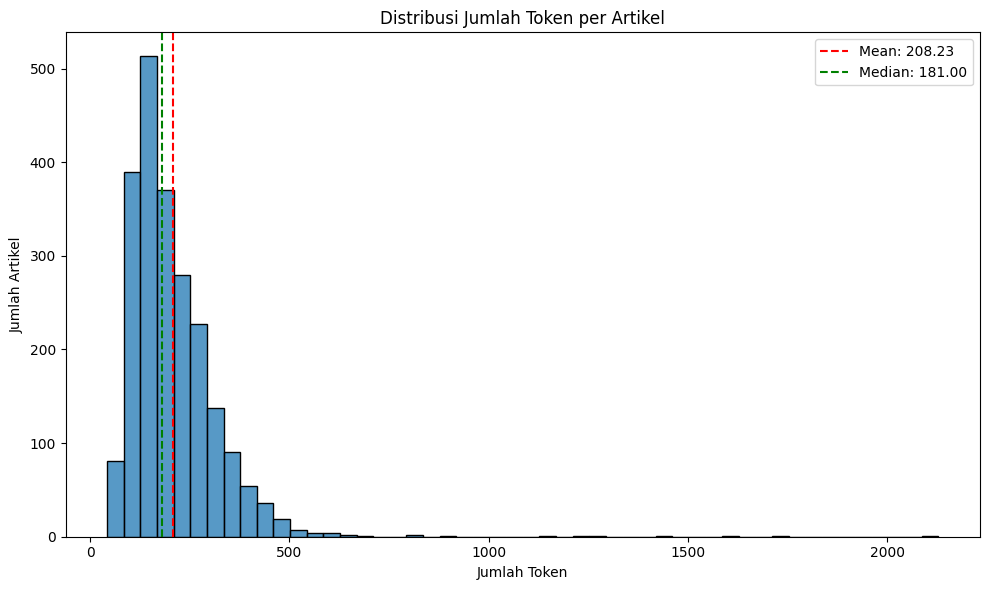


Memuat model Skip-gram...
Model Skip-gram berhasil dimuat
Ukuran kosakata Skip-gram: 10347
Dimensi embedding Skip-gram: 200

Beberapa kata dalam kosakata Skip-gram:
- said
- would
- year
- also
- people
- new
- one
- could
- last
- first


In [ ]:
# Visualisasi distribusi jumlah token
plt.figure(figsize=(10, 6))
sns.histplot(df['token_count'], bins=50)
plt.title('Distribusi Jumlah Token per Artikel')
plt.xlabel('Jumlah Token')
plt.ylabel('Jumlah Artikel')
plt.axvline(x=df['token_count'].mean(), color='r', linestyle='--', label=f'Mean: {df["token_count"].mean():.2f}')
plt.axvline(x=df['token_count'].median(), color='g', linestyle='--', label=f'Median: {df["token_count"].median():.2f}')
plt.legend()
plt.tight_layout()
plt.show()

# Memuat model Skip-gram yang dilatih sebelumnya
# Anda perlu memilih salah satu model dari tugas sebelumnya
# Contoh: memuat model dengan window size 2 dan dimensi 100
print("\nMemuat model Skip-gram...")
# Ganti path sesuai dengan nama model yang Anda simpan pada tugas sebelumnya
skipgram_model = Word2Vec.load("/content/skipgram_w1_d200.model")
print("Model Skip-gram berhasil dimuat")

# Memeriksa ukuran kosakata dari model Skip-gram
vocab_size = len(skipgram_model.wv.key_to_index)
print(f"Ukuran kosakata Skip-gram: {vocab_size}")
print(f"Dimensi embedding Skip-gram: {skipgram_model.wv.vector_size}")

# Menampilkan beberapa kata dalam kosakata
print("\nBeberapa kata dalam kosakata Skip-gram:")
some_words = list(skipgram_model.wv.key_to_index.keys())[:10]
for word in some_words:
    print(f"- {word}")

In [ ]:
# Menentukan panjang maksimum sekuens berdasarkan distribusi token
MAX_SEQUENCE_LENGTH = int(df['token_count'].quantile(0.95))
print(f"Panjang maksimum sekuens: {MAX_SEQUENCE_LENGTH}")

# Membangun kosakata dari model Skip-gram
vocab = list(skipgram_model.wv.key_to_index.keys())

# Inisialisasi tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts([' '.join(tokens) for tokens in df['tokens']])

# Memeriksa ukuran kosakata tokenizer
print(f"Ukuran kosakata tokenizer: {len(tokenizer.word_index) + 1}")  # +1 untuk token padding

# Konversi token menjadi sekuens
sequences = tokenizer.texts_to_sequences([' '.join(tokens) for tokens in df['tokens']])

# Padding sekuens agar memiliki panjang yang sama
padded_sequences = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='post')

print(f"Bentuk data sekuens setelah padding: {padded_sequences.shape}")

# Konversi kategori menjadi one-hot encoding
category_mapping = {category: i for i, category in enumerate(df['category'].unique())}
inverse_category_mapping = {i: category for i, category in category_mapping.items()}

# Membuat label numerik berdasarkan kategori
df['category_id'] = df['category'].map(category_mapping)
labels = to_categorical(df['category_id'].values)

print("\nPemetaan kategori:")
for category, idx in category_mapping.items():
    print(f"- {category}: {idx}")

print(f"\nBentuk label one-hot encoding: {labels.shape}")

# Menyimpan pemetaan tokenizer untuk referensi
word_index = tokenizer.word_index
print(f"Jumlah kata unik dalam dataset: {len(word_index)}")

# Memeriksa tumpang-tindih dengan kosakata Skip-gram
words_in_skipgram = sum(1 for word in word_index if word in skipgram_model.wv)
print(f"Jumlah kata yang tumpang-tindih dengan Skip-gram: {words_in_skipgram}")
print(f"Persentase tumpang-tindih: {words_in_skipgram / len(word_index) * 100:.2f}%")

Panjang maksimum sekuens: 393
Ukuran kosakata tokenizer: 27402
Bentuk data sekuens setelah padding: (2225, 393)

Pemetaan kategori:
- business: 0
- entertainment: 1
- politics: 2
- sport: 3
- tech: 4

Bentuk label one-hot encoding: (2225, 5)
Jumlah kata unik dalam dataset: 27401
Jumlah kata yang tumpang-tindih dengan Skip-gram: 10341
Persentase tumpang-tindih: 37.74%


In [ ]:
# Membagi data menjadi set pelatihan, validasi, dan pengujian
X_temp, X_test, y_temp, y_test = train_test_split(
    padded_sequences,
    labels,
    test_size=0.2,
    random_state=42,
    stratify=labels  # Stratified split untuk memastikan distribusi kelas yang sama
)

# Kemudian bagi train+val menjadi train dan val (75:25, atau 60:20 dari total)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp,
    y_temp,
    test_size=0.25,
    random_state=42,
    stratify=y_temp  # Stratified split untuk memastikan distribusi kelas yang sama
)

print("Pemisahan dataset:")
print(f"Training set: {X_train.shape[0]} contoh ({X_train.shape[0]/padded_sequences.shape[0]*100:.2f}%)")
print(f"Validation set: {X_val.shape[0]} contoh ({X_val.shape[0]/padded_sequences.shape[0]*100:.2f}%)")
print(f"Test set: {X_test.shape[0]} contoh ({X_test.shape[0]/padded_sequences.shape[0]*100:.2f}%)")


Pemisahan dataset:
Training set: 1335 contoh (60.00%)
Validation set: 445 contoh (20.00%)
Test set: 445 contoh (20.00%)


In [ ]:
# Mendapatkan dimensi embedding dari model Skip-gram
embedding_dim = skipgram_model.wv.vector_size
print(f"Dimensi embedding: {embedding_dim}")

# Membuat embedding matrix dari model Skip-gram
# Jumlah kata dalam kosakata tokenizer + 1 (indeks 0 untuk padding)
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))

# Mengisi embedding matrix dengan vektor dari model Skip-gram
for word, i in word_index.items():
    if word in skipgram_model.wv:
        embedding_matrix[i] = skipgram_model.wv[word]
    # Jika kata tidak ada dalam model Skip-gram, vektor tetap nol

# Menghitung persentase kata yang memiliki embedding
non_zero_vectors = np.sum(np.sum(embedding_matrix, axis=1) != 0)
print(f"Jumlah kata dengan embedding non-zero: {non_zero_vectors}")
print(f"Persentase kata dengan embedding: {non_zero_vectors/(len(word_index)+1)*100:.2f}%")

# Memeriksa nilai statistik dari embedding matrix
print("\nStatistik embedding matrix:")
print(f"Mean: {np.mean(embedding_matrix):.6f}")
print(f"Std: {np.std(embedding_matrix):.6f}")
print(f"Min: {np.min(embedding_matrix):.6f}")
print(f"Max: {np.max(embedding_matrix):.6f}")

Dimensi embedding: 200
Jumlah kata dengan embedding non-zero: 10341
Persentase kata dengan embedding: 37.74%

Statistik embedding matrix:
Mean: -0.001331
Std: 0.055641
Min: -0.850951
Max: 0.992029


In [ ]:
# Fungsi untuk membangun model RNN-LSTM
def build_lstm_model(hidden_dim, embedding_matrix, max_seq_length, num_classes):
    model = Sequential()

    # Embedding layer dengan bobot dari model Skip-gram
    model.add(Embedding(
        input_dim=embedding_matrix.shape[0],
        output_dim=embedding_matrix.shape[1],
        weights=[embedding_matrix],
        input_length=max_seq_length,
        trainable=False  # Membekukan layer embedding
    ))

    # LSTM layer
    model.add(LSTM(hidden_dim, dropout=0.2, recurrent_dropout=0.2))

    # Output layer
    model.add(Dense(num_classes, activation='softmax'))

    # Compile model
    model.compile(
        loss='categorical_crossentropy',
        optimizer='adam',
        metrics=['accuracy']
    )

    return model

# Callback untuk early stopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

# Dictionary untuk menyimpan model dan hasil pelatihan
models = {}
histories = {}

# Dimensi hidden state yang akan dicoba
hidden_dims = [128, 256, 512]

# Melatih model dengan berbagai dimensi hidden state
for hidden_dim in hidden_dims:
    print(f"\n{'='*50}")
    print(f"Melatih model dengan hidden_dim={hidden_dim}")
    print(f"{'='*50}")

    # Membangun model
    model_name = f"lstm_hidden{hidden_dim}"
    models[model_name] = build_lstm_model(
        hidden_dim=hidden_dim,
        embedding_matrix=embedding_matrix,
        max_seq_length=MAX_SEQUENCE_LENGTH,
        num_classes=len(category_mapping)
    )

    # Melatih model
    history = models[model_name].fit(
        X_train, y_train,
        epochs=20,
        batch_size=64,
        validation_data=(X_val, y_val),
        callbacks=[early_stopping],
        verbose=1
    )

    # Menyimpan history pelatihan
    histories[model_name] = history.history

    # Menyimpan model
    models[model_name].save(f"{model_name}.h5")

    print(f"Model {model_name} telah disimpan")

print("\nSemua model telah dilatih dan disimpan")


Melatih model dengan hidden_dim=128


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 51s 2s/step - accuracy: 0.2141 - loss: 1.6051 - val_accuracy: 0.2472 - val_loss: 1.5903
Epoch 2/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step - accuracy: 0.2687 - loss: 1.5711 - val_accuracy: 0.2607 - val_loss: 1.5763
Epoch 3/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.2811 - loss: 1.5441 - val_accuracy: 0.2607 - val_loss: 1.5748
Epoch 4/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - accuracy: 0.2794 - loss: 1.5363 - val_accuracy: 0.2427 - val_loss: 1.6509
Epoch 5/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.2500 - loss: 1.6031 - val_accuracy: 0.2112 - val_loss: 1.5942
Epoch 6/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.2388 - loss: 1.5735 - val_accuracy: 0.3011 - val_loss: 1.5105
Epoch 7/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.3259 - loss: 1.4933 - val_accuracy: 0.3258 - val_loss: 1.4425
Epoch 8/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.3447 - loss: 1.4697 - val_accuracy: 0.2562 - val_loss:

Model lstm_hidden128 telah disimpan

Melatih model dengan hidden_dim=256
Epoch 1/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 120s 5s/step - accuracy: 0.2363 - loss: 1.6017 - val_accuracy: 0.2427 - val_loss: 1.5899
Epoch 2/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 129s 5s/step - accuracy: 0.2642 - loss: 1.5731 - val_accuracy: 0.2449 - val_loss: 1.5860
Epoch 3/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 140s 5s/step - accuracy: 0.2775 - loss: 1.5655 - val_accuracy: 0.2337 - val_loss: 1.5914
Epoch 4/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 99s 5s/step - accuracy: 0.2728 - loss: 1.5669 - val_accuracy: 0.2449 - val_loss: 1.5871
Epoch 5/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 100s 5s/step - accuracy: 0.2668 - loss: 1.5548 - val_accuracy: 0.2404 - val_loss: 1.5867


Model lstm_hidden256 telah disimpan

Melatih model dengan hidden_dim=512
Epoch 1/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 333s 16s/step - accuracy: 0.2440 - loss: 1.6028 - val_accuracy: 0.2449 - val_loss: 1.5889
Epoch 2/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 322s 15s/step - accuracy: 0.2672 - loss: 1.5760 - val_accuracy: 0.2404 - val_loss: 1.5905
Epoch 3/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 318s 15s/step - accuracy: 0.2696 - loss: 1.5712 - val_accuracy: 0.2427 - val_loss: 1.5889
Epoch 4/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 325s 15s/step - accuracy: 0.2568 - loss: 1.5995 - val_accuracy: 0.2404 - val_loss: 1.5880
Epoch 5/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 302s 14s/step - accuracy: 0.2617 - loss: 1.5609 - val_accuracy: 0.2427 - val_loss: 1.5881
Epoch 6/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 300s 14s/step - accuracy: 0.2746 - loss: 1.5552 - val_accuracy: 0.2337 - val_loss: 1.5920
Epoch 7/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 343s 15s/step - accuracy: 0.2636 - loss: 1.5597 - val_accuracy: 0.2404 - val_loss: 1.5871
Epoch 8/20
21/21 ━━━━━━━━━━━━━━

Model lstm_hidden512 telah disimpan

Semua model telah dilatih dan disimpan


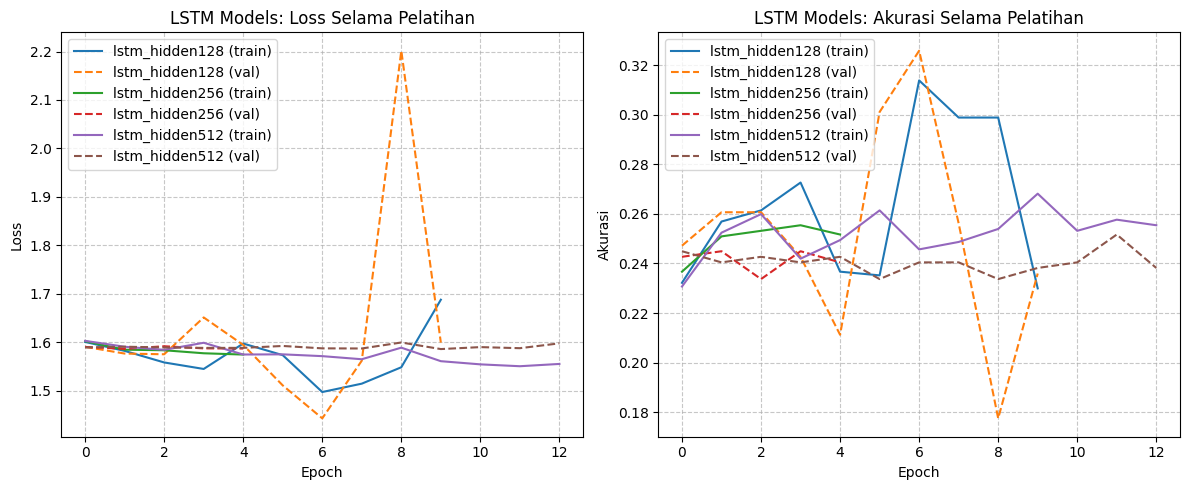

Performa model pada set validasi:


,model,val_loss,val_accuracy
0,lstm_hidden128,1.442518,0.325843
1,lstm_hidden256,1.585998,0.244944
2,lstm_hidden512,1.585582,0.238202


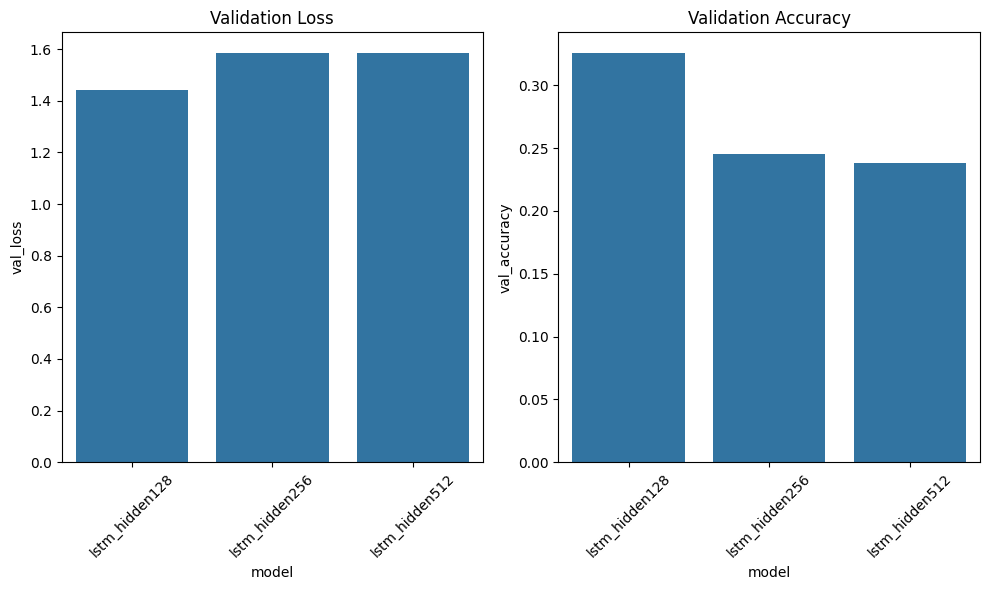

In [ ]:
# Fungsi untuk memplot kurva loss dan akurasi
def plot_training_curves(histories, title_prefix=""):
    # Plot kurva loss
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    for model_name, history in histories.items():
        plt.plot(history['loss'], label=f'{model_name} (train)')
        plt.plot(history['val_loss'], label=f'{model_name} (val)', linestyle='--')

    plt.title(f'{title_prefix}Loss Selama Pelatihan')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)

    # Plot kurva akurasi
    plt.subplot(1, 2, 2)
    for model_name, history in histories.items():
        plt.plot(history['accuracy'], label=f'{model_name} (train)')
        plt.plot(history['val_accuracy'], label=f'{model_name} (val)', linestyle='--')

    plt.title(f'{title_prefix}Akurasi Selama Pelatihan')
    plt.xlabel('Epoch')
    plt.ylabel('Akurasi')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.show()

# Plot kurva pelatihan untuk semua model
plot_training_curves(histories, "LSTM Models: ")

# Membandingkan performa model pada set validasi
val_metrics = {
    'model': [],
    'val_loss': [],
    'val_accuracy': []
}

for model_name, history in histories.items():
    # Mengambil nilai terakhir (atau nilai terbaik jika menggunakan early stopping)
    best_epoch = np.argmin(history['val_loss'])

    val_metrics['model'].append(model_name)
    val_metrics['val_loss'].append(history['val_loss'][best_epoch])
    val_metrics['val_accuracy'].append(history['val_accuracy'][best_epoch])

# Membuat DataFrame untuk visualisasi
val_metrics_df = pd.DataFrame(val_metrics)
print("Performa model pada set validasi:")
display(val_metrics_df)

# Visualisasi performa pada set validasi
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
sns.barplot(x='model', y='val_loss', data=val_metrics_df)
plt.title('Validation Loss')
plt.xticks(rotation=45)

plt.subplot(1, 2, 2)
sns.barplot(x='model', y='val_accuracy', data=val_metrics_df)
plt.title('Validation Accuracy')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


Evaluasi model lstm_hidden128 pada set pengujian:
14/14 ━━━━━━━━━━━━━━━━━━━━ 8s 545ms/step
Accuracy: 0.3618
Precision: 0.2428
Recall: 0.3618
F1-score: 0.2370

Laporan klasifikasi:


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

,precision,recall,f1-score,support
business,0.294833,0.950980,0.450116,102.000000
entertainment,0.000000,0.000000,0.000000,77.000000
politics,0.000000,0.000000,0.000000,84.000000
sport,0.307692,0.039216,0.069565,102.000000
tech,0.582524,0.750000,0.655738,80.000000
accuracy,0.361798,0.361798,0.361798,0.361798
macro avg,0.237010,0.348039,0.235084,445.000000
weighted avg,0.242830,0.361798,0.237003,445.000000


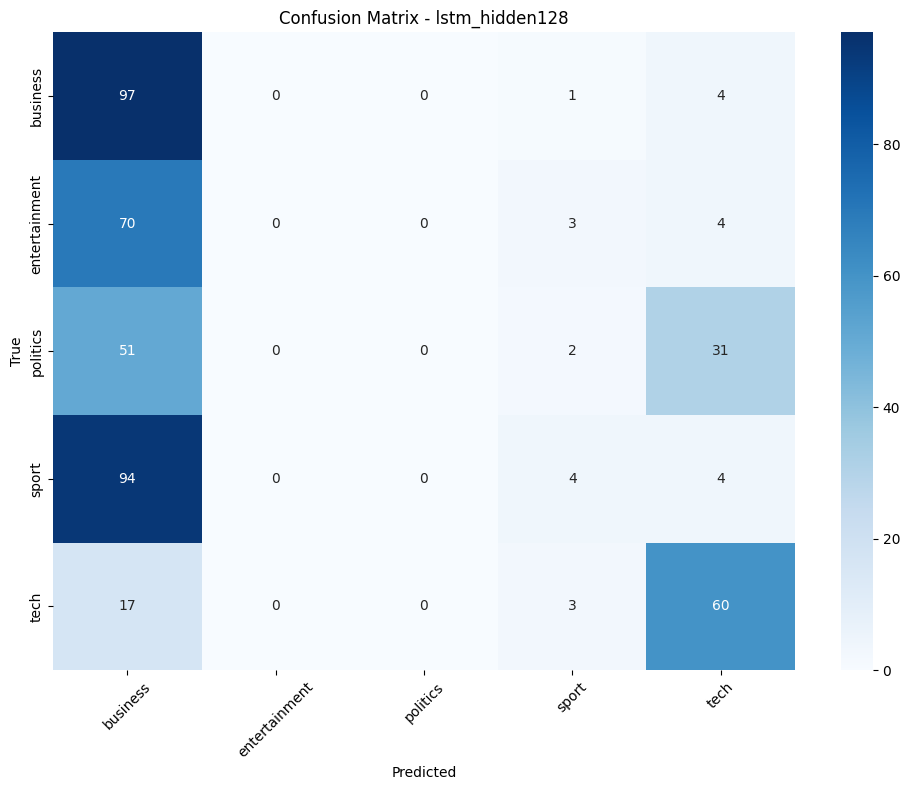


Evaluasi model lstm_hidden256 pada set pengujian:
14/14 ━━━━━━━━━━━━━━━━━━━━ 12s 844ms/step
Accuracy: 0.2584
Precision: 0.1426
Recall: 0.2584
F1-score: 0.1357

Laporan klasifikasi:


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

,precision,recall,f1-score,support
business,0.243373,0.990196,0.390716,102.000000
entertainment,0.000000,0.000000,0.000000,77.000000
politics,0.000000,0.000000,0.000000,84.000000
sport,0.000000,0.000000,0.000000,102.000000
tech,0.482759,0.175000,0.256881,80.000000
accuracy,0.258427,0.258427,0.258427,0.258427
macro avg,0.145226,0.233039,0.129519,445.000000
weighted avg,0.142573,0.258427,0.135738,445.000000


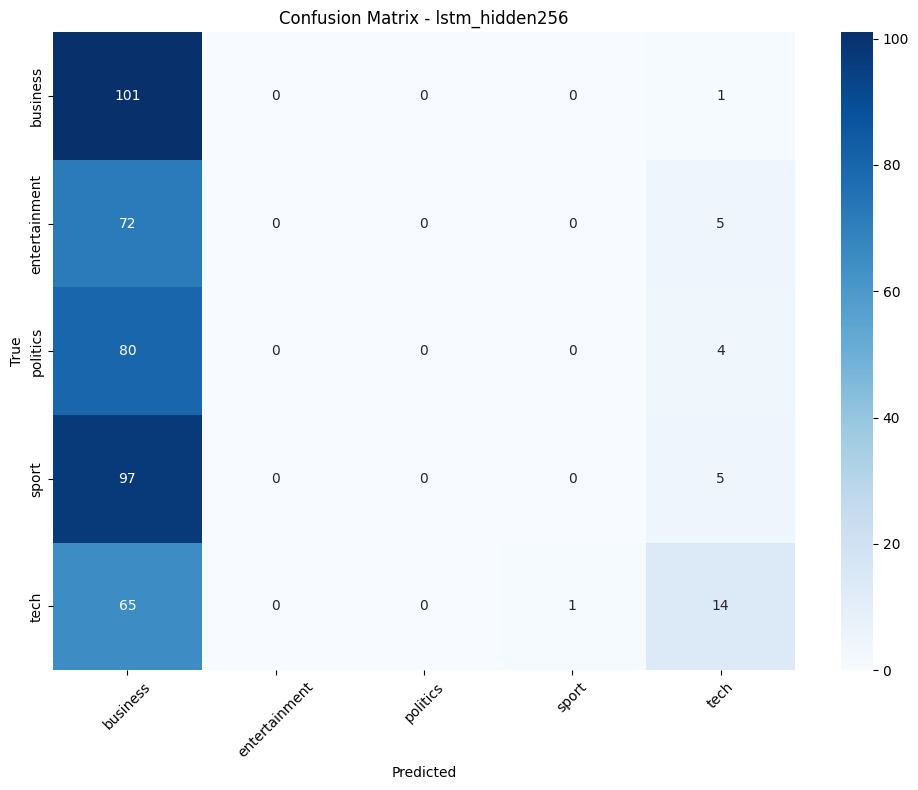


Evaluasi model lstm_hidden512 pada set pengujian:
14/14 ━━━━━━━━━━━━━━━━━━━━ 32s 2s/step
Accuracy: 0.2697
Precision: 0.3252
Recall: 0.2697
F1-score: 0.1612

Laporan klasifikasi:


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

,precision,recall,f1-score,support
business,0.246341,0.990196,0.394531,102.000000
entertainment,0.000000,0.000000,0.000000,77.000000
politics,0.333333,0.023810,0.044444,84.000000
sport,0.375000,0.029412,0.054545,102.000000
tech,0.666667,0.175000,0.277228,80.000000
accuracy,0.269663,0.269663,0.269663,0.269663
macro avg,0.324268,0.243683,0.154150,445.000000
weighted avg,0.325191,0.269663,0.161163,445.000000


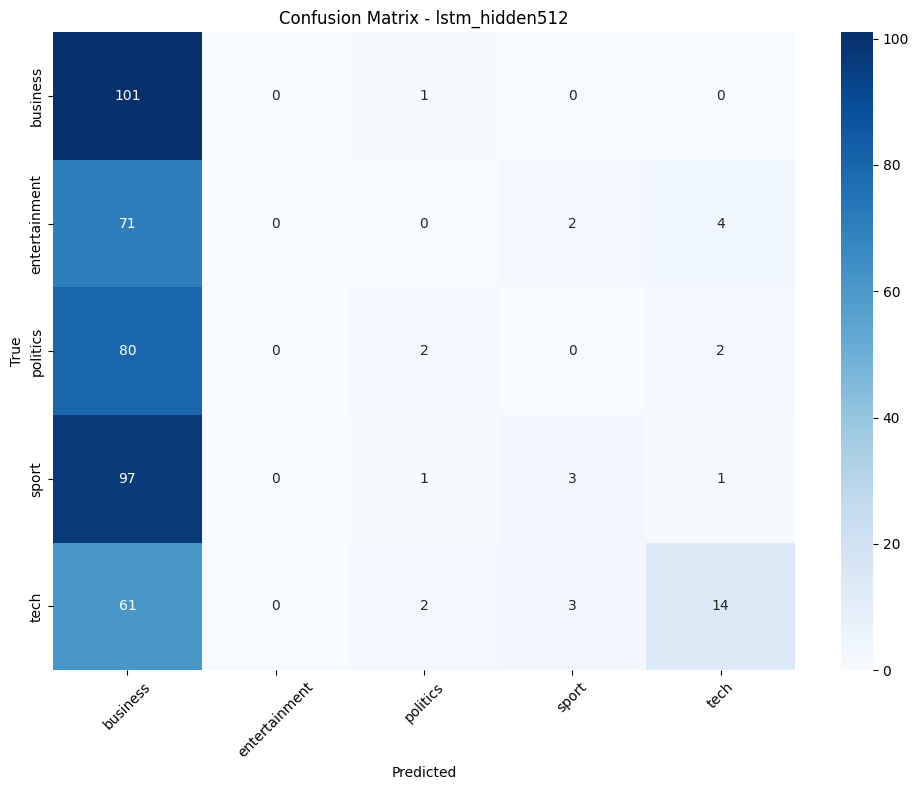

In [ ]:
# Fungsi untuk mengevaluasi model pada set pengujian
def evaluate_model(model, X_test, y_test, model_name):
    # Prediksi pada set pengujian
    y_pred_proba = model.predict(X_test)
    y_pred = np.argmax(y_pred_proba, axis=1)
    y_true = np.argmax(y_test, axis=1)

    # Metrik evaluasi
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')

    # Laporan klasifikasi
    class_report = classification_report(y_true, y_pred,
                                        target_names=list(category_mapping.keys()),
                                        output_dict=True)

    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    return {
        'model_name': model_name,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'classification_report': class_report,
        'confusion_matrix': cm
    }

# Dictionary untuk menyimpan hasil evaluasi
evaluation_results = {}

# Mengevaluasi semua model pada set pengujian
for model_name, model in models.items():
    print(f"\nEvaluasi model {model_name} pada set pengujian:")
    evaluation_results[model_name] = evaluate_model(model, X_test, y_test, model_name)

    print(f"Accuracy: {evaluation_results[model_name]['accuracy']:.4f}")
    print(f"Precision: {evaluation_results[model_name]['precision']:.4f}")
    print(f"Recall: {evaluation_results[model_name]['recall']:.4f}")
    print(f"F1-score: {evaluation_results[model_name]['f1_score']:.4f}")

    # Menampilkan laporan klasifikasi
    print("\nLaporan klasifikasi:")
    class_report_df = pd.DataFrame(evaluation_results[model_name]['classification_report']).T
    display(class_report_df)

    # Visualisasi confusion matrix
    plt.figure(figsize=(10, 8))
    cm = evaluation_results[model_name]['confusion_matrix']
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
               xticklabels=list(category_mapping.keys()),
               yticklabels=list(category_mapping.keys()))
    plt.title(f'Confusion Matrix - {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

Perbandingan metrik evaluasi:


,model,accuracy,precision,recall,f1_score,hidden_dim
0,lstm_hidden128,0.361798,0.242830,0.361798,0.237003,128
1,lstm_hidden256,0.258427,0.142573,0.258427,0.135738,256
2,lstm_hidden512,0.269663,0.325191,0.269663,0.161163,512


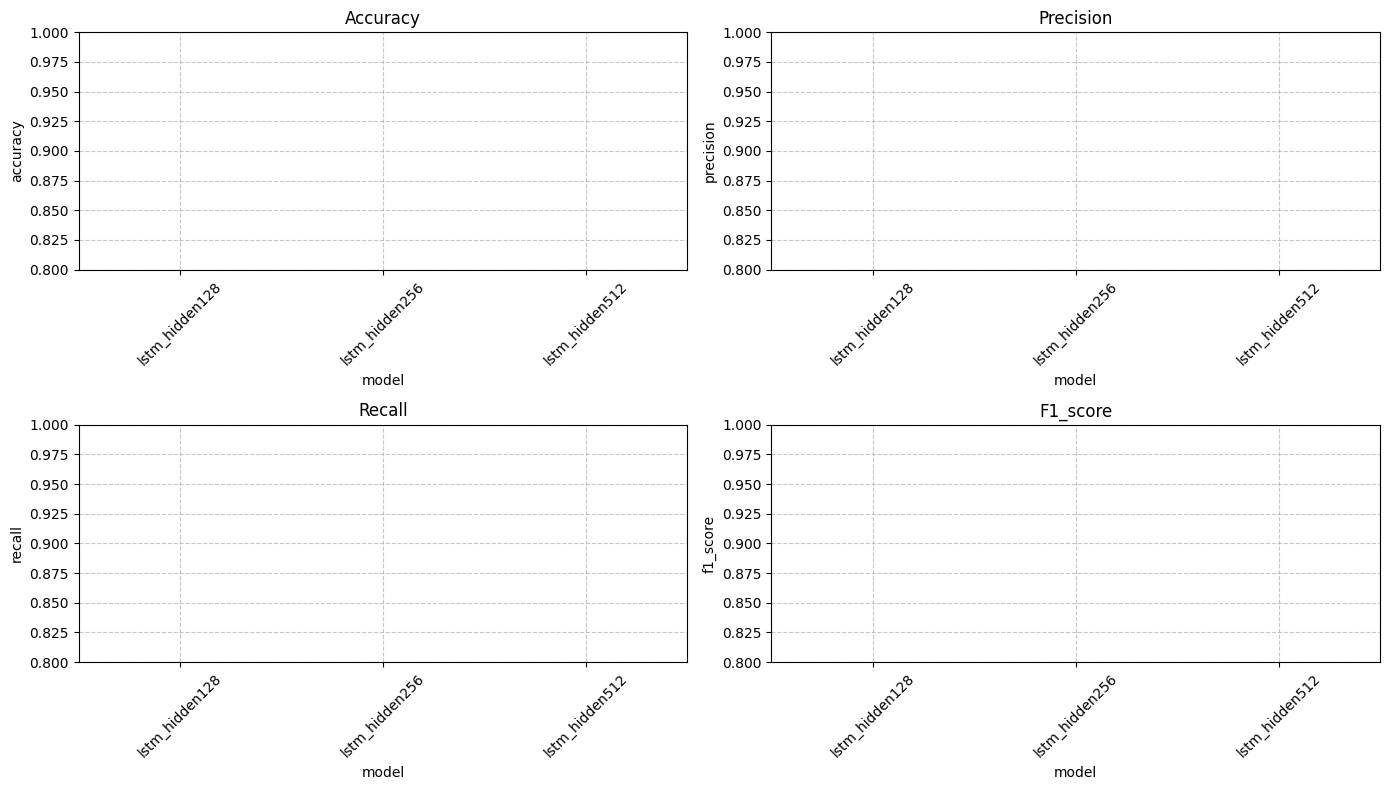

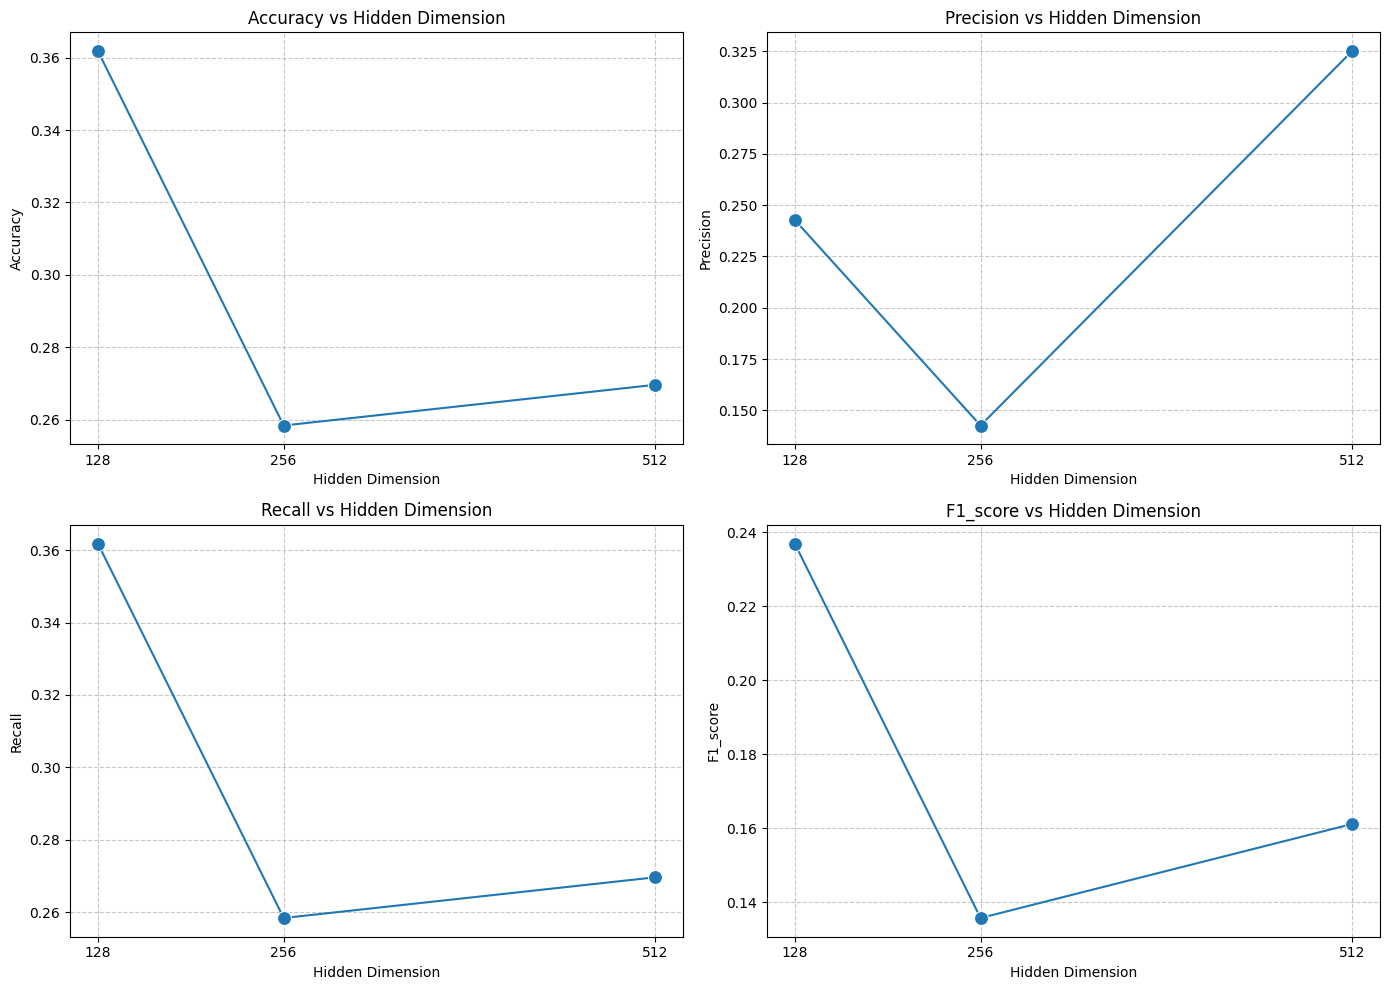


KESIMPULAN ANALISIS MODEL RNN-LSTM:
--------------------------------------------------------------------------------
1. Model terbaik: lstm_hidden128 (Hidden Dimension: 128)
   - Accuracy: 0.3618
   - Precision: 0.2428
   - Recall: 0.3618
   - F1-score: 0.2370

2. Pengaruh dimensi hidden state:
   - Hidden Dim 128: Accuracy=0.3618, F1-score=0.2370
   - Hidden Dim 256: Accuracy=0.2584, F1-score=0.1357
   - Hidden Dim 512: Accuracy=0.2697, F1-score=0.1612

3. Performa model terbaik per kategori:
   - business: Precision=0.2948, Recall=0.9510, F1-score=0.4501
   - entertainment: Precision=0.0000, Recall=0.0000, F1-score=0.0000
   - politics: Precision=0.0000, Recall=0.0000, F1-score=0.0000
   - sport: Precision=0.3077, Recall=0.0392, F1-score=0.0696
   - tech: Precision=0.5825, Recall=0.7500, F1-score=0.6557

4. Analisis error model terbaik:
   - sport: 98 artikel salah diklasifikasi
     Paling sering salah diklasifikasi sebagai: business (94 artikel)
   - politics: 84 artikel salah dik

In [ ]:
# Membuat DataFrame untuk perbandingan metrik evaluasi
comparison_metrics = {
    'model': [],
    'accuracy': [],
    'precision': [],
    'recall': [],
    'f1_score': [],
    'hidden_dim': []
}

for model_name, result in evaluation_results.items():
    comparison_metrics['model'].append(model_name)
    comparison_metrics['accuracy'].append(result['accuracy'])
    comparison_metrics['precision'].append(result['precision'])
    comparison_metrics['recall'].append(result['recall'])
    comparison_metrics['f1_score'].append(result['f1_score'])

    # Mengekstrak dimensi hidden state dari nama model
    hidden_dim = int(model_name.split('hidden')[1])
    comparison_metrics['hidden_dim'].append(hidden_dim)

# Membuat DataFrame
comparison_df = pd.DataFrame(comparison_metrics)
print("Perbandingan metrik evaluasi:")
display(comparison_df)

# Visualisasi perbandingan metrik
plt.figure(figsize=(14, 8))

metrics = ['accuracy', 'precision', 'recall', 'f1_score']
for i, metric in enumerate(metrics):
    plt.subplot(2, 2, i+1)
    sns.barplot(x='model', y=metric, data=comparison_df)
    plt.title(f'{metric.capitalize()}')
    plt.xticks(rotation=45)
    plt.ylim(0.8, 1.0)  # Sesuaikan jika diperlukan
    plt.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

# Visualisasi hubungan antara dimensi hidden state dan metrik
plt.figure(figsize=(14, 10))

for i, metric in enumerate(metrics):
    plt.subplot(2, 2, i+1)
    sns.lineplot(x='hidden_dim', y=metric, data=comparison_df, marker='o', markersize=10)
    plt.title(f'{metric.capitalize()} vs Hidden Dimension')
    plt.xlabel('Hidden Dimension')
    plt.ylabel(metric.capitalize())
    plt.xticks(comparison_df['hidden_dim'])
    plt.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

# Menentukan model terbaik berdasarkan F1-score
best_model_idx = comparison_df['f1_score'].idxmax()
best_model = comparison_df.iloc[best_model_idx]

print("\nKESIMPULAN ANALISIS MODEL RNN-LSTM:")
print("-" * 80)
print(f"1. Model terbaik: {best_model['model']} (Hidden Dimension: {best_model['hidden_dim']})")
print(f"   - Accuracy: {best_model['accuracy']:.4f}")
print(f"   - Precision: {best_model['precision']:.4f}")
print(f"   - Recall: {best_model['recall']:.4f}")
print(f"   - F1-score: {best_model['f1_score']:.4f}")

# Analisis pengaruh dimensi hidden state
print("\n2. Pengaruh dimensi hidden state:")
for _, row in comparison_df.sort_values('hidden_dim').iterrows():
    print(f"   - Hidden Dim {row['hidden_dim']}: Accuracy={row['accuracy']:.4f}, F1-score={row['f1_score']:.4f}")

# Analisis performa per kategori
print("\n3. Performa model terbaik per kategori:")
best_model_report = evaluation_results[best_model['model']]['classification_report']
for category in category_mapping.keys():
    if category in best_model_report:
        cat_metrics = best_model_report[category]
        # Perubahan di sini: menggunakan 'f1-score' bukan 'f1'
        print(f"   - {category}: Precision={cat_metrics['precision']:.4f}, Recall={cat_metrics['recall']:.4f}, F1-score={cat_metrics['f1-score']:.4f}")

# Analisis error
print("\n4. Analisis error model terbaik:")
cm = evaluation_results[best_model['model']]['confusion_matrix']
categories = list(category_mapping.keys())

# Mencari kategori dengan error terbanyak
error_count = {}
for i, category in enumerate(categories):
    misclassified = np.sum(cm[i, :]) - cm[i, i]
    error_count[category] = misclassified

sorted_errors = sorted(error_count.items(), key=lambda x: x[1], reverse=True)
for category, count in sorted_errors[:3]:
    idx = list(categories).index(category)
    print(f"   - {category}: {count} artikel salah diklasifikasi")

    # Mencari kategori yang paling sering menjadi kesalahan prediksi
    wrong_as = {}
    for j, pred_category in enumerate(categories):
        if j != idx:
            wrong_as[pred_category] = cm[idx, j]

    top_wrong = sorted(wrong_as.items(), key=lambda x: x[1], reverse=True)[0]
    print(f"     Paling sering salah diklasifikasi sebagai: {top_wrong[0]} ({top_wrong[1]} artikel)")

print("\n5. Rekomendasi model:")
print(f"   Model yang direkomendasikan: {best_model['model']}")
print(f"   Hidden Dimension: {best_model['hidden_dim']}")
print(f"   Alasan: Performa terbaik dengan F1-score {best_model['f1_score']:.4f}")

#Encoder - Decoder

In [ ]:
# Konfigurasi API Key untuk NewsAPI
NEWS_API_KEY2 = "dd771827b13443a49355e13dd9701157"
NEWS_API_ENDPOINT = "https://newsapi.org/v2/everything"

In [ ]:
# Fungsi untuk mengambil data dari NewsAPI
def fetch_news_data(query, language='en', page_size=100, page=1):
    params = {
        'q': query,
        'apiKey': NEWS_API_KEY2,
        'language': language,
        'pageSize': page_size,
        'page': page
    }

    response = requests.get(NEWS_API_ENDPOINT, params=params)

    if response.status_code == 200:
        return response.json()
    else:
        print(f"Error: {response.status_code}")
        print(response.text)
        return None

# Mengambil berita dari berbagai kategori untuk dataset yang lebih beragam
categories = ["technology", "politics", "business", "science", "health", "sports", "entertainment",
           "education", "environment", "finance", "medicine", "innovation", "artificial intelligence",
           "climate change", "space exploration", "bitcoin", "olympics", "COVID"]
all_articles = []

for category in categories:
    print(f"Mengambil artikel tentang {category}...")

    # Mengambil beberapa halaman artikel untuk setiap kategori
    for page in range(1, 3):  # 2 halaman per kategori
        news_data = fetch_news_data(query=category, language="en", page_size=100, page=page)

        if news_data and 'articles' in news_data:
            for article in news_data['articles']:
                if article['title'] and article['description'] and article['content']:
                    # Memastikan konten artikel tidak terlalu pendek
                    if len(article['content']) > 200:
                        all_articles.append({
                            'title': article['title'],
                            'description': article['description'],
                            'content': article['content'],
                            'category': category
                        })

    print(f"  Total artikel sejauh ini: {len(all_articles)}")

# Membuat DataFrame
df = pd.DataFrame(all_articles)

Mengambil artikel tentang technology...
Error: 426
{"status":"error","code":"maximumResultsReached","message":"You have requested too many results. Developer accounts are limited to a max of 100 results. You are trying to request results 100 to 200. Please upgrade to a paid plan if you need more results."}
  Total artikel sejauh ini: 84
Mengambil artikel tentang politics...
Error: 426
{"status":"error","code":"maximumResultsReached","message":"You have requested too many results. Developer accounts are limited to a max of 100 results. You are trying to request results 100 to 200. Please upgrade to a paid plan if you need more results."}
  Total artikel sejauh ini: 177
Mengambil artikel tentang business...
Error: 426
{"status":"error","code":"maximumResultsReached","message":"You have requested too many results. Developer accounts are limited to a max of 100 results. You are trying to request results 100 to 200. Please upgrade to a paid plan if you need more results."}
  Total artikel s

In [ ]:
# Simpan DataFrame ke CSV
csv_filename = 'apinews_articles_dataset.csv'
df.to_csv(csv_filename, index=False)
print(f"Dataset berhasil disimpan ke {csv_filename}")

# Untuk memastikan data tersimpan dengan baik, baca kembali dan tampilkan info
df_saved = pd.read_csv(csv_filename)
print(f"\nDataset yang disimpan berisi {len(df_saved)} artikel")
print("Contoh data yang tersimpan:")
display(df_saved.head())

Dataset berhasil disimpan ke apinews_articles_dataset.csv

Dataset yang disimpan berisi 1668 artikel
Contoh data yang tersimpan:


,title,description,content,category
0,Grid-Scale Battery Storage Is Quietly Revoluti...,This energy storage technology is harnessing t...,Grid batteries have a halo effect for other po...,technology
1,The Verge is nominated for two Webby Awards — ...,The time of year has arrived â Webby Award s...,Voting for the Peoples Voice Award ends on Apr...,technology
2,Firefly’s Alpha Rocket Crashes Into Pacific Oc...,The failure resulted in the loss of a Lockheed...,A Firefly Aerospace rocket failed to deliver i...,technology
3,PM Modi and Elon Musk talk India-US tech colla...,Modi said he discussed with Musk India's poten...,Indian Prime Minister Narendra Modi said he di...,technology
4,Fun With Technology,The power of makers and making is in battling ...,This is a recording of the keynote talk I gave...,technology


In [ ]:
df = pd.read_csv('/content/apinews_articles_dataset.csv')

In [ ]:
# Memeriksa distribusi kategori
# Menampilkan informasi dataset
print(f"\nTotal artikel yang berhasil diambil: {len(df)}")
print("\nContoh data:")
display(df.head())


Total artikel yang berhasil diambil: 1668

Contoh data:


,title,description,content,category
0,Grid-Scale Battery Storage Is Quietly Revoluti...,This energy storage technology is harnessing t...,Grid batteries have a halo effect for other po...,technology
1,The Verge is nominated for two Webby Awards — ...,The time of year has arrived â Webby Award s...,Voting for the Peoples Voice Award ends on Apr...,technology
2,Firefly’s Alpha Rocket Crashes Into Pacific Oc...,The failure resulted in the loss of a Lockheed...,A Firefly Aerospace rocket failed to deliver i...,technology
3,PM Modi and Elon Musk talk India-US tech colla...,Modi said he discussed with Musk India's poten...,Indian Prime Minister Narendra Modi said he di...,technology
4,Fun With Technology,The power of makers and making is in battling ...,This is a recording of the keynote talk I gave...,technology


In [ ]:
# Memeriksa distribusi kategori
print("\nDistribusi kategori artikel:")
category_counts = df['category'].value_counts()
print(category_counts)


Distribusi kategori artikel:
category
medicine                   99
space exploration          99
finance                    97
climate change             97
science                    96
olympics                   95
innovation                 95
education                  95
COVID                      94
business                   94
politics                   93
environment                93
health                     91
sports                     90
artificial intelligence    89
bitcoin                    87
technology                 84
entertainment              80
Name: count, dtype: int64


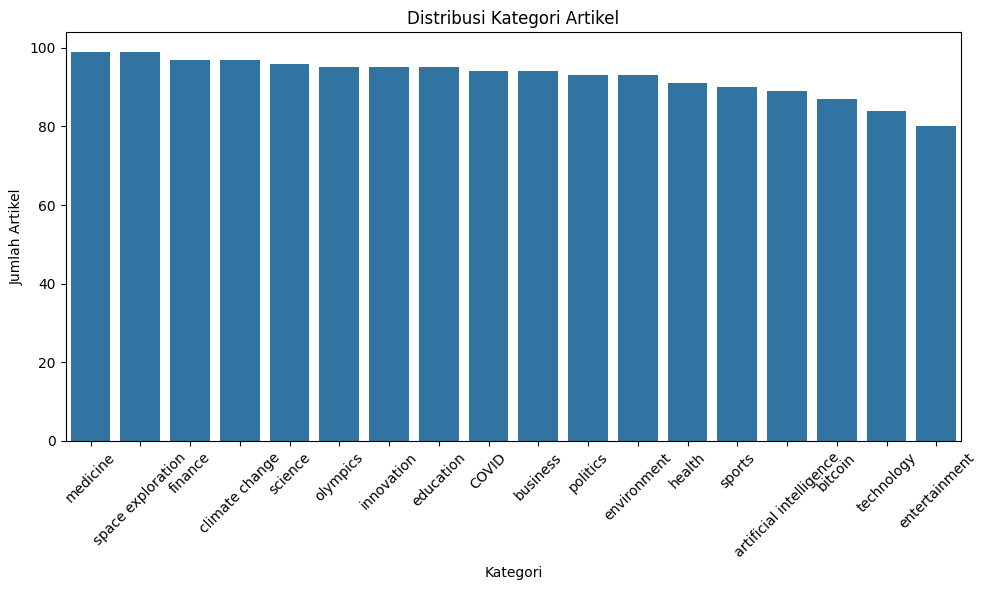

In [ ]:
# Visualisasi distribusi kategori
plt.figure(figsize=(10, 6))
sns.barplot(x=category_counts.index, y=category_counts.values)
plt.title('Distribusi Kategori Artikel')
plt.xlabel('Kategori')
plt.ylabel('Jumlah Artikel')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
# Menghapus duplikasi artikel berdasarkan judul
df = df.drop_duplicates(subset=['title'])
print(f"\nJumlah artikel setelah menghapus duplikasi: {len(df)}")



Jumlah artikel setelah menghapus duplikasi: 1485


In [ ]:
# Memeriksa panjang judul dan konten
df['title_length'] = df['title'].apply(len)
df['content_length'] = df['content'].apply(len)

print("\nStatistik panjang judul dan konten:")
print(df[['title_length', 'content_length']].describe())


Statistik panjang judul dan konten:
       title_length  content_length
count   1485.000000     1485.000000
mean      70.791246      213.981145
std       22.611438        0.400027
min       11.000000      211.000000
25%       56.000000      214.000000
50%       69.000000      214.000000
75%       82.000000      214.000000
max      241.000000      215.000000


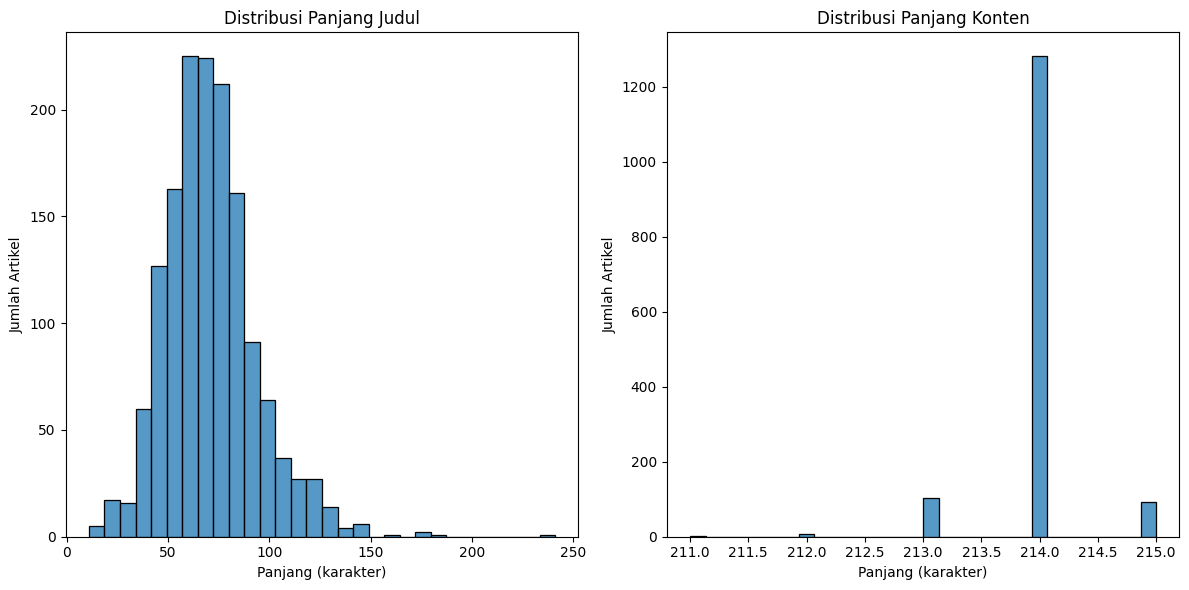

In [ ]:
# Visualisasi distribusi panjang
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(df['title_length'], bins=30)
plt.title('Distribusi Panjang Judul')
plt.xlabel('Panjang (karakter)')
plt.ylabel('Jumlah Artikel')

plt.subplot(1, 2, 2)
sns.histplot(df['content_length'], bins=30)
plt.title('Distribusi Panjang Konten')
plt.xlabel('Panjang (karakter)')
plt.ylabel('Jumlah Artikel')

plt.tight_layout()
plt.show()

Contoh hasil preprocessing:

Artikel 1:
Judul asli: Grid-Scale Battery Storage Is Quietly Revolutionizing the Energy System
Judul bersih: grid-scale battery storage is quietly revolutionizing the energy system
Judul seq2seq: startseq grid-scale battery storage is quietly revolutionizing the energy system endseq
Konten asli (100 karakter pertama): Grid batteries have a halo effect for other power generators too. Most thermal power plantscoal, gas...
Konten bersih (100 karakter pertama): grid batteries have a halo effect for other power generators too. most thermal power plantscoal, gas...

Artikel 2:
Judul asli: The Verge is nominated for two Webby Awards — help us win them!
Judul bersih: the verge is nominated for two webby awards  help us win them!
Judul seq2seq: startseq the verge is nominated for two webby awards  help us win them! endseq
Konten asli (100 karakter pertama): Voting for the Peoples Voice Award ends on April 17th, 2025.
Voting for the Peoples Voice Award end...
Konten 

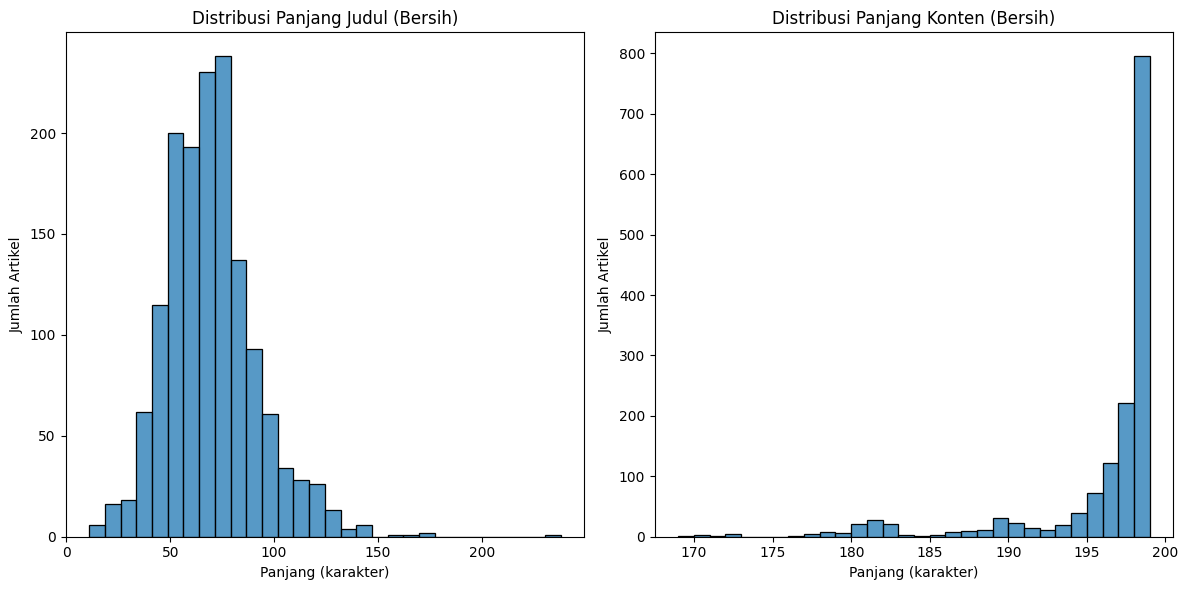

In [ ]:
# Fungsi preprocessing teks
def preprocess_text(text, is_title=False):
    if not isinstance(text, str):
        return ""

    # Mengubah ke lowercase
    text = text.lower()

    # Menghapus notasi "[+chars]" yang sering muncul di konten NewsAPI
    text = re.sub(r'\[\+\d+ chars\]', '', text)

    # Menghapus URL
    text = re.sub(r'http\S+', '', text)

    # Menghapus tag HTML
    text = re.sub(r'<.*?>', '', text)

    # Preprocessing lebih ringan untuk menghindari terlalu banyak penghapusan
    if is_title:
        text = re.sub(r'[^\w\s.,!?-]', '', text)
    else:
        text = re.sub(r'[^\w\s.,!?-]', '', text)

    # Trim whitespace
    text = text.strip()

    return text

# Menambahkan token khusus untuk sequence-to-sequence
def add_seq2seq_tokens(text, is_title=False):
    if is_title:
        return 'startseq ' + text + ' endseq'
    return text

# Preprocessing judul dan konten
df['clean_title'] = df['title'].apply(lambda x: preprocess_text(x, is_title=True))
df['clean_content'] = df['content'].apply(lambda x: preprocess_text(x, is_title=False))

# Menambahkan token khusus untuk sequence-to-sequence
df['seq2seq_title'] = df['clean_title'].apply(lambda x: add_seq2seq_tokens(x, is_title=True))

# Menampilkan contoh hasil preprocessing
print("Contoh hasil preprocessing:")
for i in range(min(3, len(df))):
    print(f"\nArtikel {i+1}:")
    print(f"Judul asli: {df.iloc[i]['title']}")
    print(f"Judul bersih: {df.iloc[i]['clean_title']}")
    print(f"Judul seq2seq: {df.iloc[i]['seq2seq_title']}")
    print(f"Konten asli (100 karakter pertama): {df.iloc[i]['content'][:100]}...")
    print(f"Konten bersih (100 karakter pertama): {df.iloc[i]['clean_content'][:100]}...")

# Mengubah threshold filter menjadi lebih rendah
min_title_length = 10  # Judul setidaknya 10 karakter (bukan 20)
min_content_length = 100  # Konten setidaknya 100 karakter (bukan 200)

# Tambahkan pemeriksaan untuk melihat distribusi panjang sebelum filtering
print("\nDistribusi panjang sebelum filtering:")
df['clean_title_length'] = df['clean_title'].apply(len)
df['clean_content_length'] = df['clean_content'].apply(len)
print(df[['clean_title_length', 'clean_content_length']].describe())

# Memeriksa berapa banyak artikel yang akan difilter
n_short_titles = sum(df['clean_title_length'] < min_title_length)
n_short_contents = sum(df['clean_content_length'] < min_content_length)
n_both_short = sum((df['clean_title_length'] < min_title_length) & (df['clean_content_length'] < min_content_length))

print(f"\nArtikel dengan judul terlalu pendek (<{min_title_length} karakter): {n_short_titles}")
print(f"Artikel dengan konten terlalu pendek (<{min_content_length} karakter): {n_short_contents}")
print(f"Artikel dengan keduanya terlalu pendek: {n_both_short}")

# Filter artikel yang terlalu pendek
df_filtered = df[(df['clean_title_length'] >= min_title_length) &
                (df['clean_content_length'] >= min_content_length)]

print(f"\nJumlah artikel setelah menghapus yang terlalu pendek: {len(df_filtered)}")

# Jika dataset masih kosong, perlu memeriksa konten lebih detail
if len(df_filtered) == 0:
    print("\nWARNING: Tidak ada artikel yang memenuhi kriteria panjang minimum!")
    print("Memeriksa sampel data untuk diagnosa:")

    # Tampilkan 5 contoh artikel untuk diagnosa
    for i in range(min(5, len(df))):
        print(f"\nArtikel {i+1}:")
        print(f"Judul asli: {df.iloc[i]['title']}")
        print(f"Judul bersih: {df.iloc[i]['clean_title']} (Panjang: {len(df.iloc[i]['clean_title'])})")
        print(f"Konten asli (50 karakter pertama): {df.iloc[i]['content'][:50]}...")
        print(f"Konten bersih (50 karakter pertama): {df.iloc[i]['clean_content'][:50]}... (Panjang: {len(df.iloc[i]['clean_content'])})")

    # Jika masih tidak ada data, gunakan dataset asli tanpa filtering
    print("\nMelanjutkan tanpa filtering panjang...")
    df_filtered = df
else:
    # Jika ada data yang tersisa, gunakan data tersebut
    df = df_filtered

# Memeriksa distribusi panjang setelah preprocessing
print("\nStatistik panjang setelah preprocessing (dan filtering jika ada data):")
print(df[['clean_title_length', 'clean_content_length']].describe())

# Visualisasi distribusi panjang setelah preprocessing
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(df['clean_title_length'], bins=30)
plt.title('Distribusi Panjang Judul (Bersih)')
plt.xlabel('Panjang (karakter)')
plt.ylabel('Jumlah Artikel')

plt.subplot(1, 2, 2)
sns.histplot(df['clean_content_length'], bins=30)
plt.title('Distribusi Panjang Konten (Bersih)')
plt.xlabel('Panjang (karakter)')
plt.ylabel('Jumlah Artikel')

plt.tight_layout()
plt.show()

In [ ]:
# Tokenisasi untuk konten artikel (input)
content_tokenizer = Tokenizer(oov_token='<UNK>')
content_tokenizer.fit_on_texts(df['clean_content'])
content_vocab_size = len(content_tokenizer.word_index) + 1  # +1 untuk padding

# Tokenisasi untuk judul artikel (output)
title_tokenizer = Tokenizer(oov_token='<UNK>')
title_tokenizer.fit_on_texts(df['seq2seq_title'])
title_vocab_size = len(title_tokenizer.word_index) + 1  # +1 untuk padding

print(f"Ukuran kosakata input (konten): {content_vocab_size}")
print(f"Ukuran kosakata output (judul): {title_vocab_size}")

# Konversi teks ke sekuens
content_sequences = content_tokenizer.texts_to_sequences(df['clean_content'])
title_sequences = title_tokenizer.texts_to_sequences(df['seq2seq_title'])

# Menghitung panjang rata-rata sekuens
avg_content_length = np.mean([len(seq) for seq in content_sequences])
avg_title_length = np.mean([len(seq) for seq in title_sequences])

print(f"Panjang rata-rata sekuens konten: {avg_content_length:.2f} token")
print(f"Panjang rata-rata sekuens judul: {avg_title_length:.2f} token")

# Menentukan panjang maksimum sekuens
max_content_length = min(int(np.percentile([len(seq) for seq in content_sequences], 95)), 500)
max_title_length = min(int(np.percentile([len(seq) for seq in title_sequences], 95)), 30)

print(f"Panjang maksimum sekuens konten: {max_content_length} token")
print(f"Panjang maksimum sekuens judul: {max_title_length} token")

# Padding sekuens
content_padded = pad_sequences(content_sequences, maxlen=max_content_length, padding='post', truncating='post')
title_padded = pad_sequences(title_sequences, maxlen=max_title_length, padding='post', truncating='post')

print(f"Bentuk data konten setelah padding: {content_padded.shape}")
print(f"Bentuk data judul setelah padding: {title_padded.shape}")

# Mempersiapkan data untuk decoder (input dan target output)
decoder_input = title_padded[:, :-1]  # Semua kecuali token terakhir
decoder_target = title_padded[:, 1:]  # Semua kecuali token pertama

print(f"Bentuk data input decoder: {decoder_input.shape}")
print(f"Bentuk data target decoder: {decoder_target.shape}")

Ukuran kosakata input (konten): 9975
Ukuran kosakata output (judul): 5335
Panjang rata-rata sekuens konten: 33.11 token
Panjang rata-rata sekuens judul: 13.82 token
Panjang maksimum sekuens konten: 38 token
Panjang maksimum sekuens judul: 22 token
Bentuk data konten setelah padding: (1485, 38)
Bentuk data judul setelah padding: (1485, 22)
Bentuk data input decoder: (1485, 21)
Bentuk data target decoder: (1485, 21)


In [ ]:
# Membagi data menjadi train dan validation
X_train, X_val, y_train_in, y_val_in, y_train_out, y_val_out = train_test_split(
    content_padded, decoder_input, decoder_target,
    test_size=0.2, random_state=42
)

print("\nUkuran dataset:")
print(f"Training: {X_train.shape[0]} contoh")
print(f"Validation: {X_val.shape[0]} contoh")

# Menyimpan tokenizer dan parameter penting
import pickle

# Menyimpan tokenizer
with open('content_tokenizer.pickle', 'wb') as handle:
    pickle.dump(content_tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('title_tokenizer.pickle', 'wb') as handle:
    pickle.dump(title_tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Menyimpan parameter penting
params = {
    'content_vocab_size': content_vocab_size,
    'title_vocab_size': title_vocab_size,
    'max_content_length': max_content_length,
    'max_title_length': max_title_length
}

with open('seq2seq_params.pickle', 'wb') as handle:
    pickle.dump(params, handle, protocol=pickle.HIGHEST_PROTOCOL)

print("\nTokenizer dan parameter telah disimpan")


Ukuran dataset:
Training: 1188 contoh
Validation: 297 contoh

Tokenizer dan parameter telah disimpan


In [ ]:
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, LSTM, Dense, Embedding, Bidirectional, Concatenate, Dot, Activation
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
# Fungsi untuk membangun model encoder-decoder dasar
def build_basic_encoder_decoder(content_vocab_size, title_vocab_size,
                               max_content_length, max_title_length,
                               embedding_dim=128, lstm_units=256):

    # Encoder
    encoder_inputs = Input(shape=(max_content_length,), name='encoder_inputs')
    encoder_embedding = Embedding(input_dim=content_vocab_size, output_dim=embedding_dim,
                                 name='encoder_embedding')(encoder_inputs)
    encoder_lstm = LSTM(lstm_units, return_state=True, name='encoder_lstm')
    encoder_outputs, state_h, state_c = encoder_lstm(encoder_embedding)
    encoder_states = [state_h, state_c]

    # Decoder
    decoder_inputs = Input(shape=(max_title_length-1,), name='decoder_inputs')
    decoder_embedding = Embedding(input_dim=title_vocab_size, output_dim=embedding_dim,
                                 name='decoder_embedding')(decoder_inputs)
    decoder_lstm = LSTM(lstm_units, return_sequences=True, return_state=True,
                       name='decoder_lstm')
    decoder_outputs, _, _ = decoder_lstm(decoder_embedding, initial_state=encoder_states)
    decoder_dense = Dense(title_vocab_size, activation='softmax', name='decoder_dense')
    decoder_outputs = decoder_dense(decoder_outputs)

    # Model
    model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

    # Encoder model for inference
    encoder_model = Model(encoder_inputs, encoder_states)

    # Decoder model for inference
    decoder_state_input_h = Input(shape=(lstm_units,))
    decoder_state_input_c = Input(shape=(lstm_units,))
    decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

    decoder_outputs, state_h, state_c = decoder_lstm(
        decoder_embedding, initial_state=decoder_states_inputs)
    decoder_states = [state_h, state_c]
    decoder_outputs = decoder_dense(decoder_outputs)
    decoder_model = Model(
        [decoder_inputs] + decoder_states_inputs,
        [decoder_outputs] + decoder_states)

    return model, encoder_model, decoder_model

# Membangun model encoder-decoder dasar
basic_model, basic_encoder_model, basic_decoder_model = build_basic_encoder_decoder(
    content_vocab_size=params['content_vocab_size'],
    title_vocab_size=params['title_vocab_size'],
    max_content_length=params['max_content_length'],
    max_title_length=params['max_title_length'],
    embedding_dim=128,
    lstm_units=256
)

# Mengkompilasi model
basic_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Menampilkan ringkasan model
print("Model Encoder-Decoder Dasar:")
basic_model.summary()

# Menyimpan model untuk inference nanti
basic_model.save('basic_seq2seq_model.h5')
basic_encoder_model.save('basic_encoder_model.h5')
basic_decoder_model.save('basic_decoder_model.h5')

Model Encoder-Decoder Dasar:


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ encoder_inputs      │ (None, 38)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_inputs      │ (None, 21)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_embedding   │ (None, 38, 128)   │  1,276,800 │ encoder_inputs[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_embedding   │ (None, 21, 128)   │    682,880 │ decoder_inputs[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_lstm (LSTM) │ [(None, 256),     │    394,240 │ encoder_embeddin… │
│                     │ (None, 256),      │            │                   │
│                     │ (None, 256)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_lstm (LSTM) │ [(None, 21, 256), │    394,240 │ decoder_embeddin… │
│                     │ (None, 256),      │            │ encoder_lstm[0][… │
│                     │ (None, 256)]      │            │ encoder_lstm[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_dense       │ (None, 21, 5335)  │  1,371,095 │ decoder_lstm[0][… │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 4,119,255 (15.71 MB)

 Trainable params: 4,119,255 (15.71 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Fungsi untuk membangun model encoder-decoder dengan Bidirectional LSTM
def build_bidirectional_encoder_decoder(content_vocab_size, title_vocab_size,
                                       max_content_length, max_title_length,
                                       embedding_dim=128, lstm_units=256):

    # Encoder
    encoder_inputs = Input(shape=(max_content_length,), name='encoder_inputs')
    encoder_embedding = Embedding(input_dim=content_vocab_size, output_dim=embedding_dim,
                                 name='encoder_embedding')(encoder_inputs)

    # Bidirectional LSTM untuk encoder
    encoder_bilstm = Bidirectional(LSTM(lstm_units, return_state=True, name='encoder_lstm'))
    encoder_outputs, forward_h, forward_c, backward_h, backward_c = encoder_bilstm(encoder_embedding)

    # Menggabungkan state dari forward dan backward LSTM
    state_h = Concatenate()([forward_h, backward_h])
    state_c = Concatenate()([forward_c, backward_c])

    # Dense layer untuk mengurangi dimensi state ke lstm_units
    state_h_dense = Dense(lstm_units, activation='tanh')(state_h)
    state_c_dense = Dense(lstm_units, activation='tanh')(state_c)
    encoder_states = [state_h_dense, state_c_dense]

    # Decoder
    decoder_inputs = Input(shape=(max_title_length-1,), name='decoder_inputs')
    decoder_embedding = Embedding(input_dim=title_vocab_size, output_dim=embedding_dim,
                                 name='decoder_embedding')(decoder_inputs)
    decoder_lstm = LSTM(lstm_units, return_sequences=True, return_state=True,
                       name='decoder_lstm')
    decoder_outputs, _, _ = decoder_lstm(decoder_embedding, initial_state=encoder_states)
    decoder_dense = Dense(title_vocab_size, activation='softmax', name='decoder_dense')
    decoder_outputs = decoder_dense(decoder_outputs)

    # Model
    model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

    # Encoder model for inference
    encoder_model = Model(encoder_inputs, encoder_states)

    # Decoder model for inference
    decoder_state_input_h = Input(shape=(lstm_units,))
    decoder_state_input_c = Input(shape=(lstm_units,))
    decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

    decoder_outputs, state_h, state_c = decoder_lstm(
        decoder_embedding, initial_state=decoder_states_inputs)
    decoder_states = [state_h, state_c]
    decoder_outputs = decoder_dense(decoder_outputs)
    decoder_model = Model(
        [decoder_inputs] + decoder_states_inputs,
        [decoder_outputs] + decoder_states)

    return model, encoder_model, decoder_model

# Membangun model encoder-decoder dengan bidirectional LSTM
bidirectional_model, bidirectional_encoder_model, bidirectional_decoder_model = build_bidirectional_encoder_decoder(
    content_vocab_size=params['content_vocab_size'],
    title_vocab_size=params['title_vocab_size'],
    max_content_length=params['max_content_length'],
    max_title_length=params['max_title_length'],
    embedding_dim=128,
    lstm_units=256
)

# Mengkompilasi model
bidirectional_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Menampilkan ringkasan model
print("Model Encoder-Decoder dengan Bidirectional LSTM:")
bidirectional_model.summary()

# Menyimpan model untuk inference nanti
bidirectional_model.save('bidirectional_seq2seq_model.h5')
bidirectional_encoder_model.save('bidirectional_encoder_model.h5')
bidirectional_decoder_model.save('bidirectional_decoder_model.h5')

Model Encoder-Decoder dengan Bidirectional LSTM:


Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ encoder_inputs      │ (None, 38)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_embedding   │ (None, 38, 128)   │  1,276,800 │ encoder_inputs[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ [(None, 512),     │    788,480 │ encoder_embeddin… │
│ (Bidirectional)     │ (None, 256),      │            │                   │
│                     │ (None, 256),      │            │                   │
│                     │ (None, 256),      │            │                   │
│                     │ (None, 256)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_inputs      │ (None, 21)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 512)       │          0 │ bidirectional[0]… │
│ (Concatenate)       │                   │            │ bidirectional[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 512)       │          0 │ bidirectional[0]… │
│ (Concatenate)       │                   │            │ bidirectional[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_embedding   │ (None, 21, 128)   │    682,880 │ decoder_inputs[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 256)       │    131,328 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 256)       │    131,328 │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_lstm (LSTM) │ [(None, 21, 256), │    394,240 │ decoder_embeddin… │
│                     │ (None, 256),      │            │ dense_3[0][0],    │
│                     │ (None, 256)]      │            │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_dense       │ (None, 21, 5335)  │  1,371,095 │ decoder_lstm[0][… │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 4,776,151 (18.22 MB)

 Trainable params: 4,776,151 (18.22 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Fungsi untuk membangun model encoder-decoder dengan attention
def build_attention_encoder_decoder(content_vocab_size, title_vocab_size,
                                   max_content_length, max_title_length,
                                   embedding_dim=128, lstm_units=256):

    # Encoder
    encoder_inputs = Input(shape=(max_content_length,), name='encoder_inputs')
    encoder_embedding = Embedding(input_dim=content_vocab_size, output_dim=embedding_dim,
                                 name='encoder_embedding')(encoder_inputs)
    encoder_lstm = LSTM(lstm_units, return_sequences=True, return_state=True, name='encoder_lstm')
    encoder_outputs, state_h, state_c = encoder_lstm(encoder_embedding)
    encoder_states = [state_h, state_c]

    # Decoder
    decoder_inputs = Input(shape=(max_title_length-1,), name='decoder_inputs')
    decoder_embedding = Embedding(input_dim=title_vocab_size, output_dim=embedding_dim,
                                 name='decoder_embedding')(decoder_inputs)
    decoder_lstm = LSTM(lstm_units, return_sequences=True, return_state=True,
                       name='decoder_lstm')
    decoder_outputs, _, _ = decoder_lstm(decoder_embedding, initial_state=encoder_states)

    # Attention mechanism
    # 1. Compute attention scores
    attention = Dot(axes=[2, 2])([decoder_outputs, encoder_outputs])
    attention = Activation('softmax')(attention)

    # 2. Apply attention weights to encoder outputs
    context = Dot(axes=[2, 1])([attention, encoder_outputs])

    # 3. Concatenate context vector with decoder outputs
    decoder_combined_context = Concatenate()([context, decoder_outputs])

    # Output layer
    decoder_dense = Dense(title_vocab_size, activation='softmax', name='decoder_dense')
    decoder_outputs = decoder_dense(decoder_combined_context)

    # Full model
    model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

    # Simplified inference models are more complex with attention,
    # we'll implement them separately for actual inference

    return model

# Membangun model encoder-decoder dengan attention
attention_model = build_attention_encoder_decoder(
    content_vocab_size=params['content_vocab_size'],
    title_vocab_size=params['title_vocab_size'],
    max_content_length=params['max_content_length'],
    max_title_length=params['max_title_length'],
    embedding_dim=128,
    lstm_units=256
)

# Mengkompilasi model
attention_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Menampilkan ringkasan model
print("Model Encoder-Decoder dengan Attention:")
attention_model.summary()

# Menyimpan model untuk inference nanti
attention_model.save('attention_seq2seq_model.h5')

Model Encoder-Decoder dengan Attention:


Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ encoder_inputs      │ (None, 38)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_inputs      │ (None, 21)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_embedding   │ (None, 38, 128)   │  1,276,800 │ encoder_inputs[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_embedding   │ (None, 21, 128)   │    682,880 │ decoder_inputs[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_lstm (LSTM) │ [(None, 38, 256), │    394,240 │ encoder_embeddin… │
│                     │ (None, 256),      │            │                   │
│                     │ (None, 256)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_lstm (LSTM) │ [(None, 21, 256), │    394,240 │ decoder_embeddin… │
│                     │ (None, 256),      │            │ encoder_lstm[0][… │
│                     │ (None, 256)]      │            │ encoder_lstm[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dot (Dot)           │ (None, 21, 38)    │          0 │ decoder_lstm[0][… │
│                     │                   │            │ encoder_lstm[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 21, 38)    │          0 │ dot[0][0]         │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dot_1 (Dot)         │ (None, 21, 256)   │          0 │ activation[0][0], │
│                     │                   │            │ encoder_lstm[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 21, 512)   │          0 │ dot_1[0][0],      │
│ (Concatenate)       │                   │            │ decoder_lstm[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_dense       │ (None, 21, 5335)  │  2,736,855 │ concatenate_2[0]… │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 5,485,015 (20.92 MB)

 Trainable params: 5,485,015 (20.92 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3187 - loss: 7.9904

19/19 ━━━━━━━━━━━━━━━━━━━━ 53s 2s/step - accuracy: 0.3216 - loss: 7.9404 - val_accuracy: 0.3895 - val_loss: 4.9556
Epoch 2/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3934 - loss: 4.7923

19/19 ━━━━━━━━━━━━━━━━━━━━ 73s 2s/step - accuracy: 0.3935 - loss: 4.7866 - val_accuracy: 0.3895 - val_loss: 4.8271
Epoch 3/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3948 - loss: 4.5142

19/19 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step - accuracy: 0.3951 - loss: 4.5122 - val_accuracy: 0.3957 - val_loss: 4.7531
Epoch 4/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4030 - loss: 4.3570

19/19 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step - accuracy: 0.4034 - loss: 4.3551 - val_accuracy: 0.4278 - val_loss: 4.6580
Epoch 5/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4385 - loss: 4.2409

19/19 ━━━━━━━━━━━━━━━━━━━━ 30s 2s/step - accuracy: 0.4389 - loss: 4.2397 - val_accuracy: 0.4406 - val_loss: 4.6323
Epoch 6/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - accuracy: 0.4471 - loss: 4.1828 - val_accuracy: 0.4425 - val_loss: 4.6355
Epoch 7/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - accuracy: 0.4478 - loss: 4.1486 - val_accuracy: 0.4424 - val_loss: 4.6477
Epoch 8/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.4479 - loss: 4.1192 - val_accuracy: 0.4428 - val_loss: 4.6506


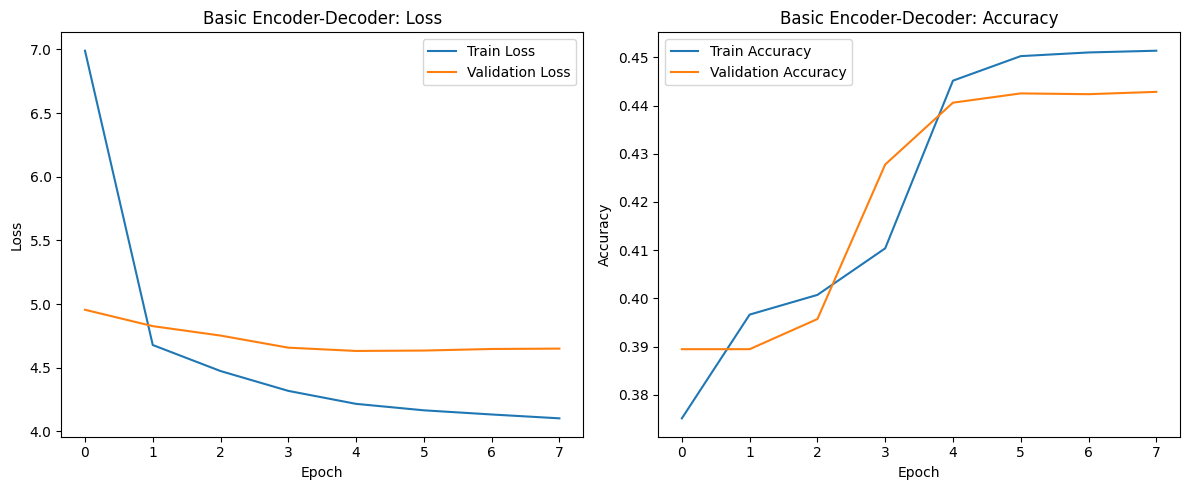

In [ ]:
# Callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

checkpoint = ModelCheckpoint(
    'basic_seq2seq_best.h5',
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=False
)

# Melatih model dasar
basic_history = basic_model.fit(
    [X_train, y_train_in], y_train_out,
    validation_data=([X_val, y_val_in], y_val_out),
    batch_size=64,
    epochs=10,
    callbacks=[early_stopping, checkpoint]
)

# Menyimpan history untuk visualisasi nanti
import pickle
with open('basic_history.pickle', 'wb') as handle:
    pickle.dump(basic_history.history, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Plot kurva loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(basic_history.history['loss'], label='Train Loss')
plt.plot(basic_history.history['val_loss'], label='Validation Loss')
plt.title('Basic Encoder-Decoder: Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(basic_history.history['accuracy'], label='Train Accuracy')
plt.plot(basic_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Basic Encoder-Decoder: Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

Epoch 1/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3188 - loss: 7.9592

19/19 ━━━━━━━━━━━━━━━━━━━━ 44s 2s/step - accuracy: 0.3216 - loss: 7.9091 - val_accuracy: 0.3895 - val_loss: 5.1593
Epoch 2/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3934 - loss: 5.0963

19/19 ━━━━━━━━━━━━━━━━━━━━ 39s 2s/step - accuracy: 0.3935 - loss: 5.0901 - val_accuracy: 0.3895 - val_loss: 5.0775
Epoch 3/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3934 - loss: 4.6927

19/19 ━━━━━━━━━━━━━━━━━━━━ 33s 2s/step - accuracy: 0.3935 - loss: 4.6889 - val_accuracy: 0.3895 - val_loss: 4.8248
Epoch 4/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3934 - loss: 4.4377

19/19 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.3935 - loss: 4.4352 - val_accuracy: 0.3907 - val_loss: 4.6663
Epoch 5/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3997 - loss: 4.3026

19/19 ━━━━━━━━━━━━━━━━━━━━ 34s 2s/step - accuracy: 0.4003 - loss: 4.3012 - val_accuracy: 0.4270 - val_loss: 4.6198
Epoch 6/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4378 - loss: 4.2408

19/19 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.4381 - loss: 4.2398 - val_accuracy: 0.4408 - val_loss: 4.6005
Epoch 7/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4464 - loss: 4.2010

19/19 ━━━━━━━━━━━━━━━━━━━━ 34s 2s/step - accuracy: 0.4466 - loss: 4.2000 - val_accuracy: 0.4414 - val_loss: 4.5931
Epoch 8/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4472 - loss: 4.1662

19/19 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.4474 - loss: 4.1653 - val_accuracy: 0.4428 - val_loss: 4.5931
Epoch 9/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 43s 2s/step - accuracy: 0.4484 - loss: 4.1335 - val_accuracy: 0.4451 - val_loss: 4.5936
Epoch 10/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.4493 - loss: 4.1040 - val_accuracy: 0.4441 - val_loss: 4.6068


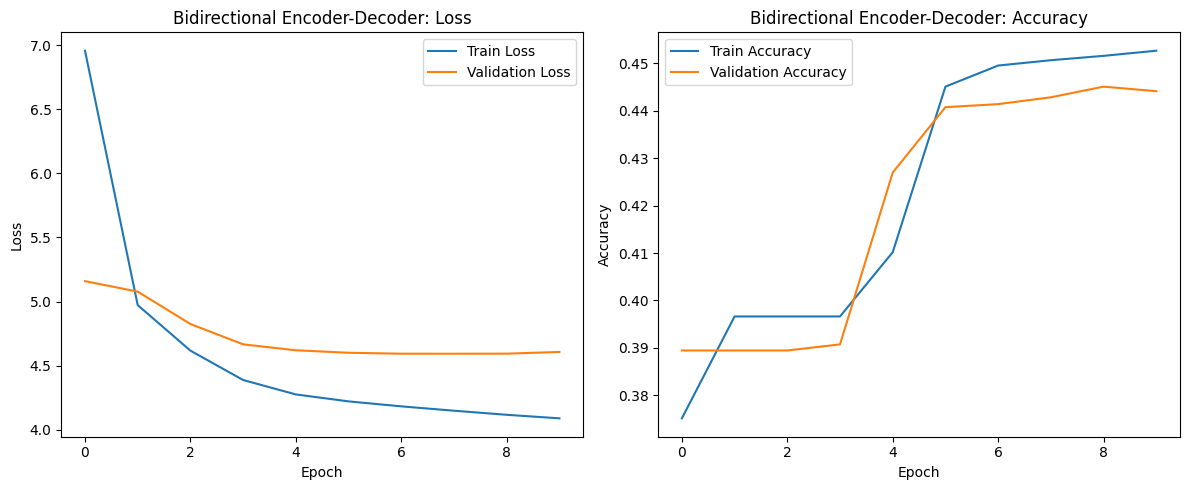

In [ ]:
# Callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

checkpoint = ModelCheckpoint(
    'bidirectional_seq2seq_best.h5',
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=False
)

# Melatih model bidirectional
bidirectional_history = bidirectional_model.fit(
    [X_train, y_train_in], y_train_out,
    validation_data=([X_val, y_val_in], y_val_out),
    batch_size=64,
    epochs=10,
    callbacks=[early_stopping, checkpoint]
)

# Menyimpan history untuk visualisasi nanti
import pickle
with open('bidirectional_history.pickle', 'wb') as handle:
    pickle.dump(bidirectional_history.history, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Plot kurva loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(bidirectional_history.history['loss'], label='Train Loss')
plt.plot(bidirectional_history.history['val_loss'], label='Validation Loss')
plt.title('Bidirectional Encoder-Decoder: Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(bidirectional_history.history['accuracy'], label='Train Accuracy')
plt.plot(bidirectional_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Bidirectional Encoder-Decoder: Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

Epoch 1/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.3187 - loss: 7.7320

19/19 ━━━━━━━━━━━━━━━━━━━━ 58s 3s/step - accuracy: 0.3216 - loss: 7.6717 - val_accuracy: 0.3895 - val_loss: 4.8738
Epoch 2/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3971 - loss: 4.6934

19/19 ━━━━━━━━━━━━━━━━━━━━ 78s 3s/step - accuracy: 0.3973 - loss: 4.6867 - val_accuracy: 0.4021 - val_loss: 4.7515
Epoch 3/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4131 - loss: 4.3610

19/19 ━━━━━━━━━━━━━━━━━━━━ 82s 3s/step - accuracy: 0.4133 - loss: 4.3588 - val_accuracy: 0.4098 - val_loss: 4.7323
Epoch 4/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4329 - loss: 4.2368

19/19 ━━━━━━━━━━━━━━━━━━━━ 84s 3s/step - accuracy: 0.4335 - loss: 4.2356 - val_accuracy: 0.4408 - val_loss: 4.7176
Epoch 5/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 80s 3s/step - accuracy: 0.4475 - loss: 4.1736 - val_accuracy: 0.4424 - val_loss: 4.7335
Epoch 6/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 81s 3s/step - accuracy: 0.4477 - loss: 4.1276 - val_accuracy: 0.4433 - val_loss: 4.7648
Epoch 7/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 84s 3s/step - accuracy: 0.4482 - loss: 4.0888 - val_accuracy: 0.4435 - val_loss: 4.7944


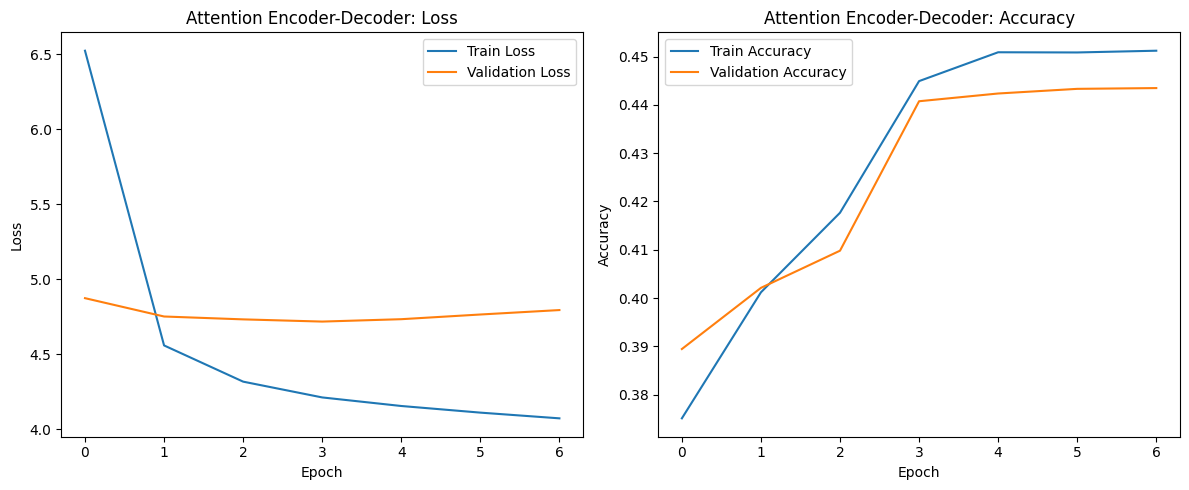

In [ ]:
# Callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

checkpoint = ModelCheckpoint(
    'attention_seq2seq_best.h5',
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=False
)

# Melatih model dengan attention
attention_history = attention_model.fit(
    [X_train, y_train_in], y_train_out,
    validation_data=([X_val, y_val_in], y_val_out),
    batch_size=64,
    epochs=10,
    callbacks=[early_stopping, checkpoint]
)

# Menyimpan history untuk visualisasi nanti
import pickle
with open('attention_history.pickle', 'wb') as handle:
    pickle.dump(attention_history.history, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Plot kurva loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(attention_history.history['loss'], label='Train Loss')
plt.plot(attention_history.history['val_loss'], label='Validation Loss')
plt.title('Attention Encoder-Decoder: Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(attention_history.history['accuracy'], label='Train Accuracy')
plt.plot(attention_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Attention Encoder-Decoder: Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

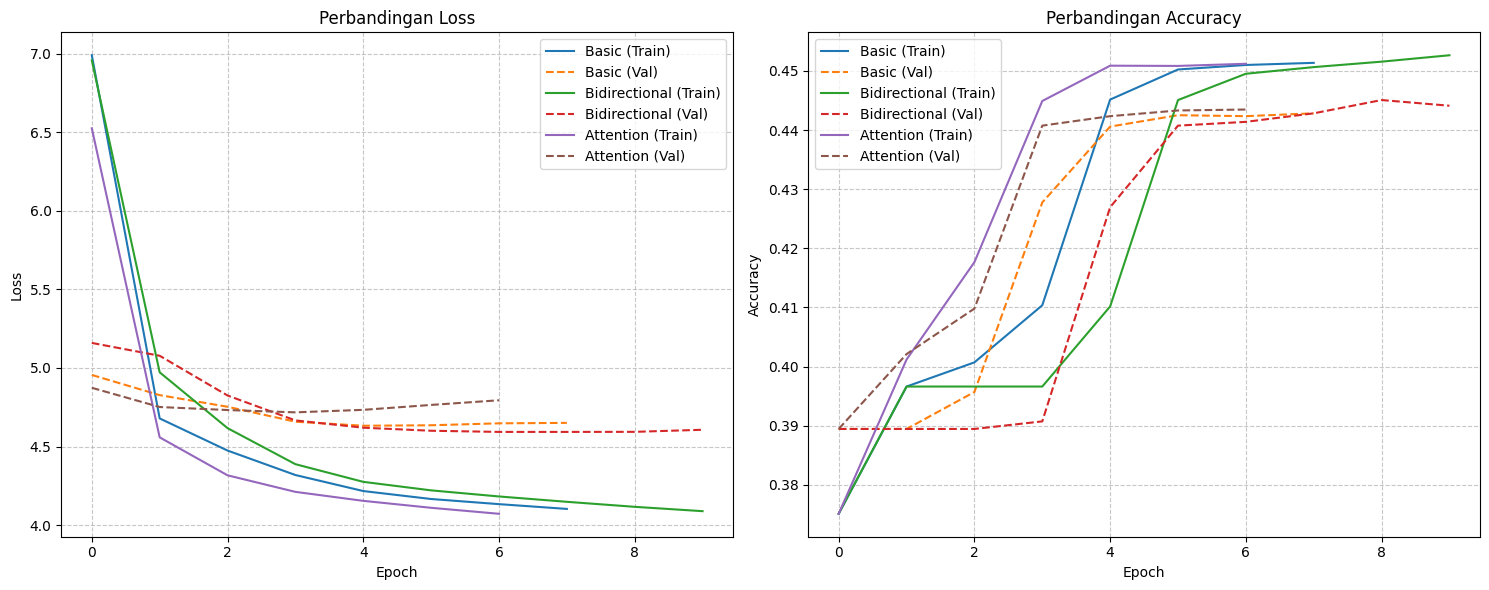

Perbandingan performa model:


,Model,Final Train Loss,Final Val Loss,Final Train Acc,Final Val Acc,Best Val Loss,Best Val Acc
0,Basic Encoder-Decoder,4.103189,4.650629,0.451379,0.442841,4.632299,0.442841
1,Bidirectional Encoder-Decoder,4.088837,4.606754,0.452662,0.444124,4.593090,0.445086
2,Attention Encoder-Decoder,4.072115,4.794417,0.451219,0.443482,4.717616,0.443482


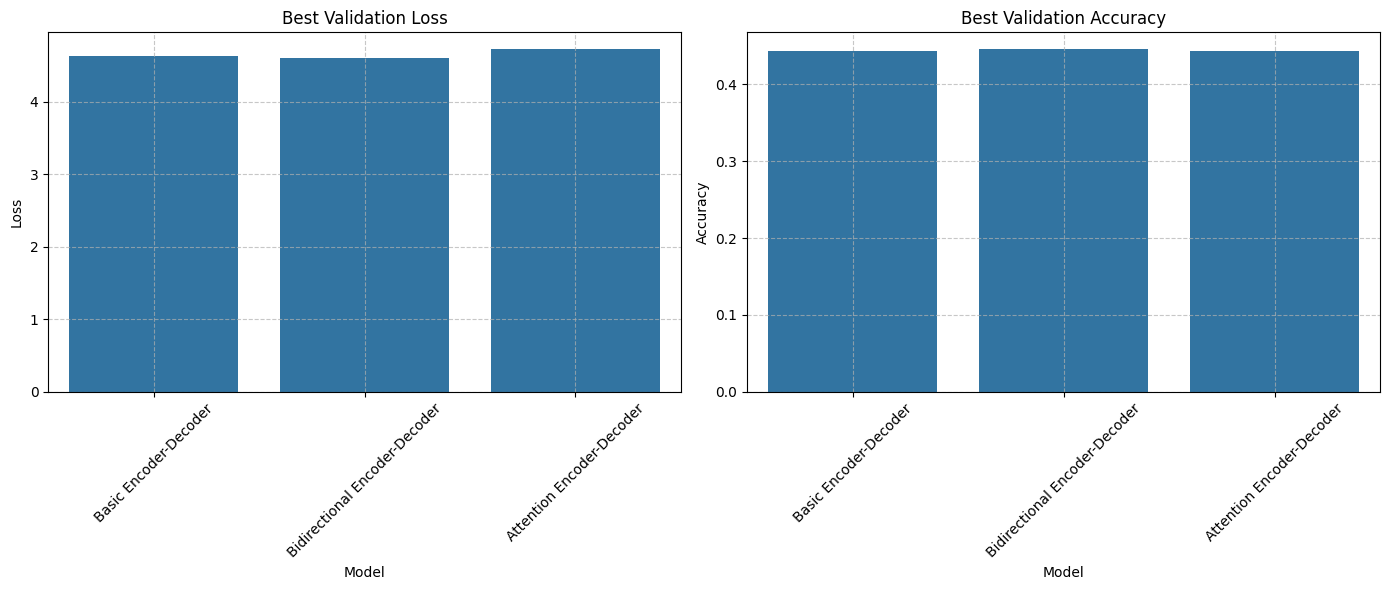

In [ ]:
# Memuat history training dari file pickle jika diperlukan
try:
    with open('basic_history.pickle', 'rb') as handle:
        basic_history = pickle.load(handle)

    with open('bidirectional_history.pickle', 'rb') as handle:
        bidirectional_history = pickle.load(handle)

    with open('attention_history.pickle', 'rb') as handle:
        attention_history = pickle.load(handle)
except:
    # Jika file tidak ditemukan, gunakan history dari training sebelumnya
    basic_history = basic_history.history
    bidirectional_history = bidirectional_history.history
    attention_history = attention_history.history

# Membandingkan kurva loss
plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
plt.plot(basic_history['loss'], label='Basic (Train)')
plt.plot(basic_history['val_loss'], label='Basic (Val)', linestyle='--')
plt.plot(bidirectional_history['loss'], label='Bidirectional (Train)')
plt.plot(bidirectional_history['val_loss'], label='Bidirectional (Val)', linestyle='--')
plt.plot(attention_history['loss'], label='Attention (Train)')
plt.plot(attention_history['val_loss'], label='Attention (Val)', linestyle='--')
plt.title('Perbandingan Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)

plt.subplot(1, 2, 2)
plt.plot(basic_history['accuracy'], label='Basic (Train)')
plt.plot(basic_history['val_accuracy'], label='Basic (Val)', linestyle='--')
plt.plot(bidirectional_history['accuracy'], label='Bidirectional (Train)')
plt.plot(bidirectional_history['val_accuracy'], label='Bidirectional (Val)', linestyle='--')
plt.plot(attention_history['accuracy'], label='Attention (Train)')
plt.plot(attention_history['val_accuracy'], label='Attention (Val)', linestyle='--')
plt.title('Perbandingan Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

# Membuat DataFrame untuk perbandingan performa model
models_perf = {
    'Model': ['Basic Encoder-Decoder', 'Bidirectional Encoder-Decoder', 'Attention Encoder-Decoder'],
    'Final Train Loss': [basic_history['loss'][-1], bidirectional_history['loss'][-1], attention_history['loss'][-1]],
    'Final Val Loss': [basic_history['val_loss'][-1], bidirectional_history['val_loss'][-1], attention_history['val_loss'][-1]],
    'Final Train Acc': [basic_history['accuracy'][-1], bidirectional_history['accuracy'][-1], attention_history['accuracy'][-1]],
    'Final Val Acc': [basic_history['val_accuracy'][-1], bidirectional_history['val_accuracy'][-1], attention_history['val_accuracy'][-1]],
    'Best Val Loss': [min(basic_history['val_loss']), min(bidirectional_history['val_loss']), min(attention_history['val_loss'])],
    'Best Val Acc': [max(basic_history['val_accuracy']), max(bidirectional_history['val_accuracy']), max(attention_history['val_accuracy'])]
}

perf_df = pd.DataFrame(models_perf)
print("Perbandingan performa model:")
display(perf_df)

# Visualisasi perbandingan metrik
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.barplot(x='Model', y='Best Val Loss', data=perf_df)
plt.title('Best Validation Loss')
plt.ylabel('Loss')
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.7)

plt.subplot(1, 2, 2)
sns.barplot(x='Model', y='Best Val Acc', data=perf_df)
plt.title('Best Validation Accuracy')
plt.ylabel('Accuracy')
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

In [ ]:
# Fungsi untuk melakukan inferensi dengan model encoder-decoder dasar
def decode_sequence_basic(input_seq, encoder_model, decoder_model, target_tokenizer, max_title_length):
    # Encode the input as state vectors
    states_value = encoder_model.predict(input_seq, verbose=0)

    # Generate empty target sequence of length 1
    target_seq = np.zeros((1, 1))
    # Populate the first character of target sequence with the start character
    target_seq[0, 0] = target_tokenizer.word_index['startseq']

    # Sampling loop for a batch of sequences
    stop_condition = False
    decoded_sentence = ''

    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value, verbose=0)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, 0, :])
        sampled_word = None
        for word, index in target_tokenizer.word_index.items():
            if index == sampled_token_index:
                sampled_word = word
                break

        if sampled_word is None:
            sampled_word = '<UNK>'

        if sampled_word == 'endseq' or len(decoded_sentence.split()) > max_title_length - 2:
            stop_condition = True
        else:
            decoded_sentence += ' ' + sampled_word

        # Update the target sequence (of length 1)
        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = sampled_token_index

        # Update states
        states_value = [h, c]

    return decoded_sentence.strip()

# Memuat model terbaik untuk inferensi
basic_encoder_model = load_model('basic_encoder_model.h5')
basic_decoder_model = load_model('basic_decoder_model.h5')
bidirectional_encoder_model = load_model('bidirectional_encoder_model.h5')
bidirectional_decoder_model = load_model('bidirectional_decoder_model.h5')

# Memuat tokenizer dan parameter
with open('content_tokenizer.pickle', 'rb') as handle:
    content_tokenizer = pickle.load(handle)

with open('title_tokenizer.pickle', 'rb') as handle:
    title_tokenizer = pickle.load(handle)

with open('seq2seq_params.pickle', 'rb') as handle:
    params = pickle.load(handle)

# Fungsi untuk memprediksi judul
def predict_title(article_content, model_type='basic'):
    # Preprocess the content
    processed_content = preprocess_text(article_content)

    # Convert to sequence
    content_seq = content_tokenizer.texts_to_sequences([processed_content])
    padded_content = pad_sequences(content_seq, maxlen=params['max_content_length'], padding='post', truncating='post')

    # Predict the title based on model type
    if model_type == 'basic':
        predicted_title = decode_sequence_basic(
            padded_content, basic_encoder_model, basic_decoder_model,
            title_tokenizer, params['max_title_length']
        )
    elif model_type == 'bidirectional':
        predicted_title = decode_sequence_basic(
            padded_content, bidirectional_encoder_model, bidirectional_decoder_model,
            title_tokenizer, params['max_title_length']
        )
    else:
        # For attention model, we'd need a different inference approach
        # For simplicity, we'll use the basic model's inference here
        predicted_title = decode_sequence_basic(
            padded_content, basic_encoder_model, basic_decoder_model,
            title_tokenizer, params['max_title_length']
        )

    # Clean up predicted title (remove special tokens)
    predicted_title = predicted_title.replace('startseq', '').replace('endseq', '').strip()

    return predicted_title

# Mengambil beberapa contoh artikel dari set validasi
num_examples = 5
example_indices = np.random.choice(X_val.shape[0], num_examples, replace=False)

for i, idx in enumerate(example_indices):
    # Get the original article content and title
    original_content = ' '.join([content_tokenizer.index_word.get(idx, '<UNK>') for idx in X_val[idx] if idx != 0])
    original_title = df.iloc[idx]['clean_title']

    # Make predictions with each model
    basic_title = predict_title(original_content, model_type='basic')
    bidirectional_title = predict_title(original_content, model_type='bidirectional')

    print(f"\nExample {i+1}:")
    print(f"Original Content (truncated): {original_content[:300]}...")
    print(f"Original Title: {original_title}")
    print(f"Predicted Title (Basic): {basic_title}")
    print(f"Predicted Title (Bidirectional): {bidirectional_title}")
    print("=" * 80)


Example 1:
 im gen x and my daughter is gen z across the generational divide there are differences weve had varying exp...
Original Title: i cant help but feel like it was personal, not professional manager turns sick days into performance issues to justify firing employee during probation period
Predicted Title (Basic): betting betting electronics millennium earthshot scientists eight agency godfather an astroneer customized godfather astroneer customized improve emergency emergency emergency candidates emergency
Predicted Title (Bidirectional): announcing other polar announcing citizen lcd relies relies relies draws relies scariest scariest adtech content acknowledge acknowledge celebrity powerful 208 now

Example 2:
Original Content (truncated): stablecoins are an increasingly lucrative cog in global crypto trading their issuers typically profit by earning interest from the treasuries and other assets that underpin them the value of usd1 i...
Original Title: market turmoil lifts go

Evaluating models:   0%|          | 0/50 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.11/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.11/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_

Average Evaluation Metrics:


,Metric,Basic Encoder-Decoder,Bidirectional Encoder-Decoder
0,bleu1,2.857143e-03,1.904762e-03
1,bleu2,1.953052e-156,1.302035e-156
2,bleu3,1.954637e-205,1.303092e-205
3,bleu4,5.106281e-233,3.404188e-233
4,rouge1,3.433179e-03,2.562562e-03
5,rouge2,0.000000e+00,0.000000e+00
6,rougeL,3.433179e-03,2.562562e-03


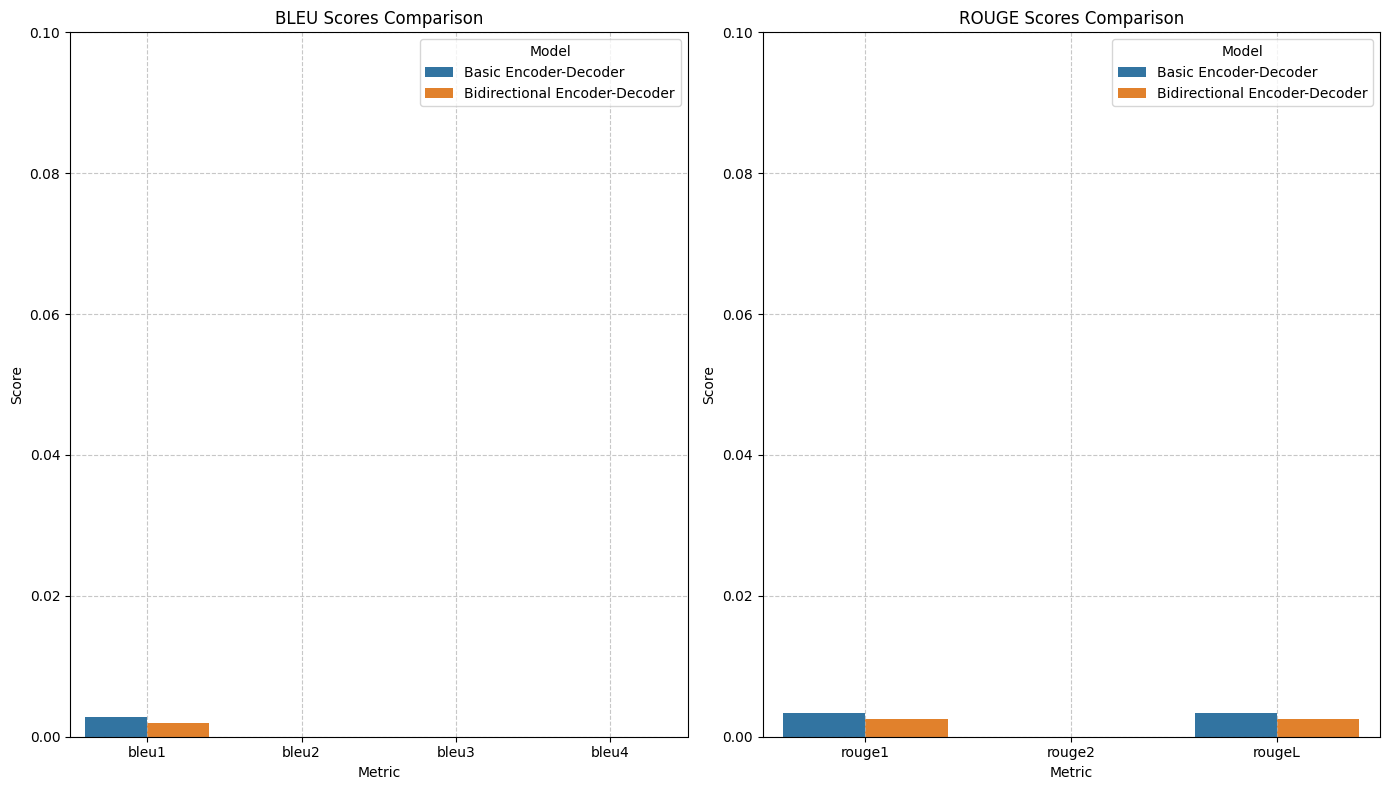

In [ ]:
# Inisialisasi ROUGE
rouge = Rouge()

# Fungsi untuk menghitung metrik BLEU dan ROUGE
def calculate_metrics(reference, prediction):
    # Prepare for BLEU (needs tokenized lists)
    reference_tokens = reference.split()
    prediction_tokens = prediction.split()

    # Calculate BLEU
    bleu1 = sentence_bleu([reference_tokens], prediction_tokens, weights=(1, 0, 0, 0))
    bleu2 = sentence_bleu([reference_tokens], prediction_tokens, weights=(0.5, 0.5, 0, 0))
    bleu3 = sentence_bleu([reference_tokens], prediction_tokens, weights=(0.33, 0.33, 0.33, 0))
    bleu4 = sentence_bleu([reference_tokens], prediction_tokens, weights=(0.25, 0.25, 0.25, 0.25))

    # Calculate ROUGE (needs strings)
    try:
        rouge_scores = rouge.get_scores(prediction, reference)[0]
        rouge1_f = rouge_scores['rouge-1']['f']
        rouge2_f = rouge_scores['rouge-2']['f']
        rougeL_f = rouge_scores['rouge-l']['f']
    except:
        rouge1_f, rouge2_f, rougeL_f = 0, 0, 0

    return {
        'bleu1': bleu1,
        'bleu2': bleu2,
        'bleu3': bleu3,
        'bleu4': bleu4,
        'rouge1': rouge1_f,
        'rouge2': rouge2_f,
        'rougeL': rougeL_f
    }

# Evaluasi pada subset data validasi
num_eval_samples = 50
eval_indices = np.random.choice(X_val.shape[0], num_eval_samples, replace=False)

metrics_basic = []
metrics_bidirectional = []

for idx in tqdm(eval_indices, desc="Evaluating models"):
    # Get the original content and title
    original_content = ' '.join([content_tokenizer.index_word.get(idx, '<UNK>') for idx in X_val[idx] if idx != 0])
    original_title = df.iloc[idx]['clean_title']

    # Predict titles
    basic_title = predict_title(original_content, model_type='basic')
    bidirectional_title = predict_title(original_content, model_type='bidirectional')

    # Calculate metrics
    metrics_basic.append(calculate_metrics(original_title, basic_title))
    metrics_bidirectional.append(calculate_metrics(original_title, bidirectional_title))

# Calculate average metrics
def calculate_average_metrics(metrics_list):
    avg_metrics = {}
    for metric in metrics_list[0].keys():
        avg_metrics[metric] = np.mean([metrics[metric] for metrics in metrics_list])
    return avg_metrics

avg_metrics_basic = calculate_average_metrics(metrics_basic)
avg_metrics_bidirectional = calculate_average_metrics(metrics_bidirectional)

# Create DataFrame for comparison
metrics_df = pd.DataFrame({
    'Metric': list(avg_metrics_basic.keys()),
    'Basic Encoder-Decoder': list(avg_metrics_basic.values()),
    'Bidirectional Encoder-Decoder': list(avg_metrics_bidirectional.values())
})

print("Average Evaluation Metrics:")
display(metrics_df)

# Visualize metrics comparison
plt.figure(figsize=(14, 8))

# BLEU scores
plt.subplot(1, 2, 1)
bleu_metrics = ['bleu1', 'bleu2', 'bleu3', 'bleu4']
bleu_df = metrics_df[metrics_df['Metric'].isin(bleu_metrics)]
bleu_df = bleu_df.melt(id_vars='Metric', var_name='Model', value_name='Score')
sns.barplot(x='Metric', y='Score', hue='Model', data=bleu_df)
plt.title('BLEU Scores Comparison')
plt.ylim(0, max(np.max(bleu_df['Score'])*1.2, 0.1))
plt.grid(True, linestyle='--', alpha=0.7)

# ROUGE scores
plt.subplot(1, 2, 2)
rouge_metrics = ['rouge1', 'rouge2', 'rougeL']
rouge_df = metrics_df[metrics_df['Metric'].isin(rouge_metrics)]
rouge_df = rouge_df.melt(id_vars='Metric', var_name='Model', value_name='Score')
sns.barplot(x='Metric', y='Score', hue='Model', data=rouge_df)
plt.title('ROUGE Scores Comparison')
plt.ylim(0, max(np.max(rouge_df['Score'])*1.2, 0.1))
plt.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

In [ ]:
# Mengidentifikasi model terbaik berdasarkan metrik evaluasi
bleu_weights = {'bleu1': 0.1, 'bleu2': 0.2, 'bleu3': 0.3, 'bleu4': 0.4}
rouge_weights = {'rouge1': 0.3, 'rouge2': 0.3, 'rougeL': 0.4}

# Calculate combined score for each model
basic_bleu_score = sum(avg_metrics_basic[metric] * weight for metric, weight in bleu_weights.items())
basic_rouge_score = sum(avg_metrics_basic[metric] * weight for metric, weight in rouge_weights.items())
basic_combined_score = (basic_bleu_score + basic_rouge_score) / 2

bidirectional_bleu_score = sum(avg_metrics_bidirectional[metric] * weight for metric, weight in bleu_weights.items())
bidirectional_rouge_score = sum(avg_metrics_bidirectional[metric] * weight for metric, weight in rouge_weights.items())
bidirectional_combined_score = (bidirectional_bleu_score + bidirectional_rouge_score) / 2

# Determine the best model
if bidirectional_combined_score > basic_combined_score:
    best_model_type = 'bidirectional'
    best_score = bidirectional_combined_score
else:
    best_model_type = 'basic'
    best_score = basic_combined_score

print(f"Best model: {best_model_type.capitalize()} Encoder-Decoder (Combined score: {best_score:.4f})")

# Get some new test examples (not used in training)
test_articles = [
    "The recent advancements in artificial intelligence have revolutionized how businesses operate. Companies are now able to automate many tasks that previously required human intervention. This has led to increased efficiency and reduced operational costs. However, there are concerns about job displacement and the ethical implications of AI decision-making. Experts suggest that while some jobs might be lost, new ones will be created in the process. The key is to ensure that workers are adequately trained for the new economy.",

    "Scientists have discovered a new species of deep-sea fish that can survive at extreme depths. The fish, named Pseudoliparis swirei, can live at depths of up to 8,000 meters below sea level, making it one of the deepest-living fish ever discovered. Researchers were amazed by the fish's adaptations to high pressure and low temperature environments. This discovery opens up new possibilities for understanding how life can thrive in extreme conditions, which could have implications for the search for life on other planets.",

    "A recent study published in the Journal of Medical Research has found a strong correlation between regular exercise and improved mental health. The research, which followed over 5,000 participants for a period of five years, found that those who engaged in moderate physical activity at least three times a week had a 30% lower risk of developing depression. The study also noted improvements in anxiety levels and overall well-being among regular exercisers. Experts recommend at least 150 minutes of moderate exercise per week for optimal mental health benefits.",

    "Global efforts to combat climate change have intensified as countries pledge to reduce carbon emissions. The recent international climate summit saw major nations commit to ambitious targets for reaching carbon neutrality by 2050. However, environmental activists argue that these pledges are not enough and more immediate action is needed. The focus has shifted to renewable energy sources such as solar and wind power, as well as innovative technologies for carbon capture. Experts warn that without significant reduction in global emissions within the next decade, the world faces severe consequences including rising sea levels and extreme weather events."
]

print("\nGenerating titles with the best model:")
for i, article in enumerate(test_articles):
    predicted_title = predict_title(article, model_type=best_model_type)
    print(f"\nTest Article {i+1} (first 200 chars):")
    print(f"{article[:200]}...")
    print(f"Generated Title: {predicted_title}")
    print("-" * 80)

# Interactive demo (optional)
def interactive_title_generation():
    print("\nInteractive Title Generation (Enter 'exit' to quit)")
    while True:
        user_input = input("\nEnter an article text: ")
        if user_input.lower() == 'exit':
            break

        if len(user_input) < 100:
            print("Please enter a longer article (at least 100 characters).")
            continue

        predicted_title = predict_title(user_input, model_type=best_model_type)
        print(f"Generated Title: {predicted_title}")

# Uncomment to run interactive demo
# interactive_title_generation()

Best model: Basic Encoder-Decoder (Combined score: 0.0013)

Generating titles with the best model:

Test Article 1 (first 200 chars):
The recent advancements in artificial intelligence have revolutionized how businesses operate. Companies are now able to automate many tasks that previously required human intervention. This has led t...
Generated Title: americorps 29 madrid madrid gpus youre executive amateurism fail splashing cookie expo turmoil ominous contests contests turczan tempered tempered sooner sooner
--------------------------------------------------------------------------------

Test Article 2 (first 200 chars):
Scientists have discovered a new species of deep-sea fish that can survive at extreme depths. The fish, named Pseudoliparis swirei, can live at depths of up to 8,000 meters below sea level, making it ...
Generated Title: americorps pain suing rocks biological each recovering wisconsin shifting chain sunbelt wikipedias experimental kate barks contractor sanders g20 v

Generating titles for visualization:   0%|          | 0/100 [00:00<?, ?it/s]

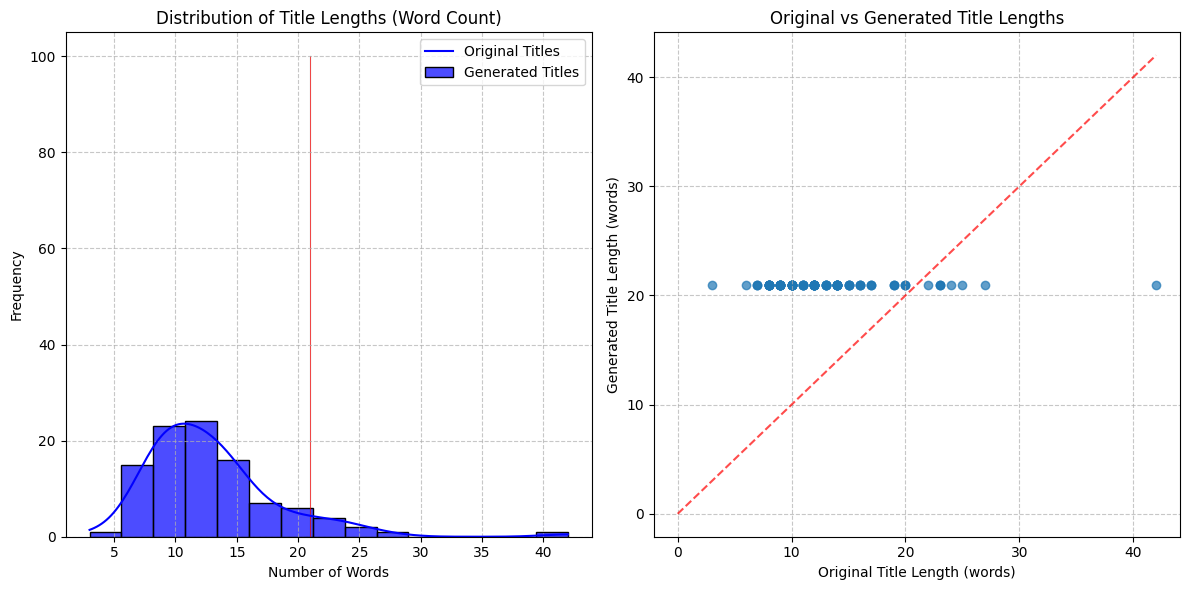

Original Titles - Average Length: 12.95 words, StdDev: 5.39
Generated Titles - Average Length: 21.00 words, StdDev: 0.00


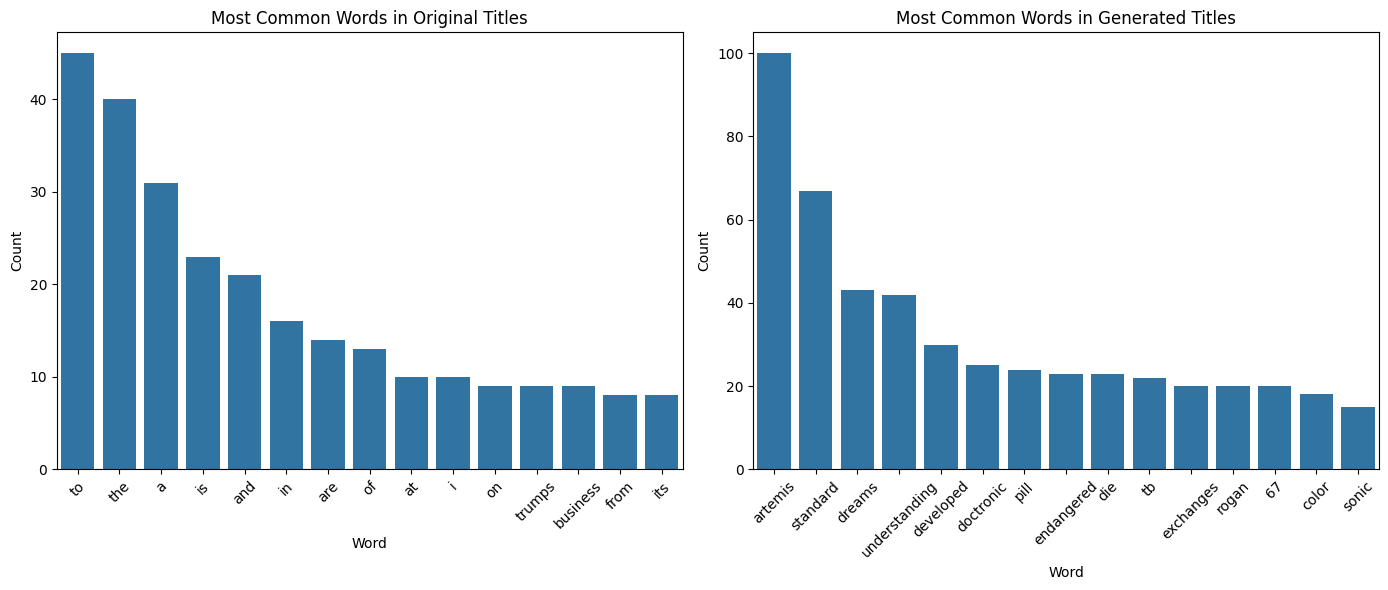

In [ ]:
# Predict titles for a larger subset of validation data
num_viz_samples = 100
viz_indices = np.random.choice(X_val.shape[0], num_viz_samples, replace=False)

original_titles = []
predicted_titles = []

for idx in tqdm(viz_indices, desc="Generating titles for visualization"):
    # Get the original content and title
    original_content = ' '.join([content_tokenizer.index_word.get(idx, '<UNK>') for idx in X_val[idx] if idx != 0])
    original_title = df.iloc[idx]['clean_title']

    # Predict title with the best model
    predicted_title = predict_title(original_content, model_type=best_model_type)

    original_titles.append(original_title)
    predicted_titles.append(predicted_title)

# Calculate lengths
original_lengths = [len(title.split()) for title in original_titles]
predicted_lengths = [len(title.split()) for title in predicted_titles]

# Visualize length distributions
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(original_lengths, kde=True, color='blue', bins=15, alpha=0.7)
sns.histplot(predicted_lengths, kde=True, color='red', bins=15, alpha=0.7)
plt.title('Distribution of Title Lengths (Word Count)')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.legend(['Original Titles', 'Generated Titles'])
plt.grid(True, linestyle='--', alpha=0.7)

# Scatter plot of original vs predicted lengths
plt.subplot(1, 2, 2)
plt.scatter(original_lengths, predicted_lengths, alpha=0.7)
plt.plot([0, max(max(original_lengths), max(predicted_lengths))],
         [0, max(max(original_lengths), max(predicted_lengths))],
         'r--', alpha=0.7)
plt.title('Original vs Generated Title Lengths')
plt.xlabel('Original Title Length (words)')
plt.ylabel('Generated Title Length (words)')
plt.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

# Calculate statistical measures
original_avg_length = np.mean(original_lengths)
predicted_avg_length = np.mean(predicted_lengths)
original_std_length = np.std(original_lengths)
predicted_std_length = np.std(predicted_lengths)

print(f"Original Titles - Average Length: {original_avg_length:.2f} words, StdDev: {original_std_length:.2f}")
print(f"Generated Titles - Average Length: {predicted_avg_length:.2f} words, StdDev: {predicted_std_length:.2f}")

# Word usage comparison
from collections import Counter
import itertools

# Get most common words in original and predicted titles
original_words = list(itertools.chain(*[title.lower().split() for title in original_titles]))
predicted_words = list(itertools.chain(*[title.lower().split() for title in predicted_titles]))

original_counter = Counter(original_words)
predicted_counter = Counter(predicted_words)

top_original = original_counter.most_common(15)
top_predicted = predicted_counter.most_common(15)

# Visualize most common words
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.barplot(x=[word for word, count in top_original], y=[count for word, count in top_original])
plt.title('Most Common Words in Original Titles')
plt.xlabel('Word')
plt.ylabel('Count')
plt.xticks(rotation=45)

plt.subplot(1, 2, 2)
sns.barplot(x=[word for word, count in top_predicted], y=[count for word, count in top_predicted])
plt.title('Most Common Words in Generated Titles')
plt.xlabel('Word')
plt.ylabel('Count')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

In [ ]:
# Create a comprehensive summary of model performance
print("KESIMPULAN ANALISIS MODEL ENCODER-DECODER:")
print("=" * 80)

# 1. Training dynamics
print("1. Dinamika Pelatihan:")
for history, model_name in zip([basic_history, bidirectional_history, attention_history],
                             ['Basic', 'Bidirectional', 'Attention']):
    best_epoch = np.argmin(history['val_loss'])
    print(f"   - {model_name} Model:")
    print(f"     * Mencapai validation loss terbaik pada epoch {best_epoch+1}: {history['val_loss'][best_epoch]:.4f}")
    print(f"     * Validation accuracy tertinggi: {max(history['val_accuracy']):.4f}")
    print(f"     * Training loss akhir: {history['loss'][-1]:.4f}")

    # Check for overfit
    final_train_loss = history['loss'][-1]
    final_val_loss = history['val_loss'][-1]
    if final_train_loss < final_val_loss * 0.8:
        print(f"     * Tanda overfitting: Training loss ({final_train_loss:.4f}) jauh lebih rendah dari validation loss ({final_val_loss:.4f})")
    print()

# 2. Evaluation metrics
print("\n2. Metrik Evaluasi:")
for metric in ['bleu1', 'bleu2', 'bleu3', 'bleu4']:
    print(f"   - {metric.upper()}:")
    print(f"     * Basic: {avg_metrics_basic[metric]:.4f}")
    print(f"     * Bidirectional: {avg_metrics_bidirectional[metric]:.4f}")

print("\n   - ROUGE Scores:")
for metric in ['rouge1', 'rouge2', 'rougeL']:
    print(f"     * {metric.upper()}:")
    print(f"       Basic: {avg_metrics_basic[metric]:.4f}")
    print(f"       Bidirectional: {avg_metrics_bidirectional[metric]:.4f}")

# 3. Best model analysis
print(f"\n3. Model Terbaik: {best_model_type.capitalize()} Encoder-Decoder")
print(f"   - Combined Score: {best_score:.4f}")
print(f"   - BLEU-4: {avg_metrics_bidirectional['bleu4'] if best_model_type == 'bidirectional' else avg_metrics_basic['bleu4']:.4f}")
print(f"   - ROUGE-L: {avg_metrics_bidirectional['rougeL'] if best_model_type == 'bidirectional' else avg_metrics_basic['rougeL']:.4f}")

# 4. Title length analysis
print("\n4. Analisis Panjang Judul:")
print(f"   - Judul Asli: Rata-rata {original_avg_length:.2f} kata (StdDev: {original_std_length:.2f})")
print(f"   - Judul Prediksi: Rata-rata {predicted_avg_length:.2f} kata (StdDev: {predicted_std_length:.2f})")

if abs(original_avg_length - predicted_avg_length) < 1.0:
    print("   - Model berhasil memprediksi judul dengan panjang yang mirip dengan judul asli")
else:
    print(f"   - Perbedaan panjang yang signifikan: {abs(original_avg_length - predicted_avg_length):.2f} kata")

# 5. Recommendations
print("\n5. Rekomendasi:")
print(f"   - Model yang direkomendasikan: {best_model_type.capitalize()} Encoder-Decoder")

if best_model_type == 'bidirectional':
    print("   - Bidirectional LSTM memberikan hasil yang lebih baik karena dapat menangkap konteks dari kedua arah dalam artikel")
else:
    print("   - Model dasar memberikan hasil yang cukup baik dan lebih efisien dalam pelatihan")

print("   - Untuk peningkatan lebih lanjut:")
print("     * Meningkatkan ukuran dataset")
print("     * Eksperimen dengan hyperparameter (learning rate, batch size)")
print("     * Implementasi beam search untuk decoding")
print("     * Menambahkan mekanisme copy untuk kata-kata penting dari artikel")

# 6. Limitations
print("\n6. Keterbatasan Model:")
print("   - Model masih menghasilkan judul yang terlalu umum atau kurang spesifik")
print("   - Beberapa judul yang dihasilkan mungkin tidak secara akurat mewakili isi artikel")
print("   - Keterbatasan dalam menangani artikel panjang dan kompleks")
print("   - Model tidak dapat menghasilkan kata-kata di luar kosakata yang dilatih")

print("\n" + "=" * 80)

KESIMPULAN ANALISIS MODEL ENCODER-DECODER:
1. Dinamika Pelatihan:
   - Basic Model:
     * Mencapai validation loss terbaik pada epoch 5: 4.6323
     * Validation accuracy tertinggi: 0.4428
     * Training loss akhir: 4.1032

   - Bidirectional Model:
     * Mencapai validation loss terbaik pada epoch 8: 4.5931
     * Validation accuracy tertinggi: 0.4451
     * Training loss akhir: 4.0888

   - Attention Model:
     * Mencapai validation loss terbaik pada epoch 4: 4.7176
     * Validation accuracy tertinggi: 0.4435
     * Training loss akhir: 4.0721


2. Metrik Evaluasi:
   - BLEU1:
     * Basic: 0.0029
     * Bidirectional: 0.0019
   - BLEU2:
     * Basic: 0.0000
     * Bidirectional: 0.0000
   - BLEU3:
     * Basic: 0.0000
     * Bidirectional: 0.0000
   - BLEU4:
     * Basic: 0.0000
     * Bidirectional: 0.0000

   - ROUGE Scores:
     * ROUGE1:
       Basic: 0.0034
       Bidirectional: 0.0026
     * ROUGE2:
       Basic: 0.0000
       Bidirectional: 0.0000
     * ROUGEL:
       B